<a href="https://colab.research.google.com/github/jithsg/MODELING/blob/main/Copy_of_Yet_another_copy_of_Hybrid_pmos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.3 MB/s eta 0:00:00


In [ ]:
import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint


device_files = [
    "pfet_120_40.csv",
    "pfet_200_40.csv",
    "pfet_200_80.csv",
    "pfet_400_40.csv",
    "pfet_800_40.csv"
]

flattened_vectors = []
per_device_raw_data = []

for path in device_files:
    df = pd.read_csv(path).sort_values(by=["Vgs(V)", "Vds(V)"])
    Id = df["Id(A)"].values
    gm = df["gm"].values
    gds = df["gds"].values
    flat = np.stack([Id, gm, gds], axis=1).flatten()
    flattened_vectors.append(flat)
    per_device_raw_data.append(df)

device_matrix = np.array(flattened_vectors)
pca = PCA(n_components=3)
device_signatures = pca.fit_transform(device_matrix)

X, y_id, y_gm, y_gd = [], [], [], []
for i, df in enumerate(per_device_raw_data):
    P = device_signatures[i]
    for _, row in df.iterrows():
        vgs = row["Vgs(V)"]
        vds = row["Vds(V)"]
        temp = row["Temp"]
        id_val = max(row["Id(A)"], 1e-12)
        gm_val = row["gm"]
        gd_val = row["gds"]
        X.append([*P, vgs, vds, temp])
        y_id.append(np.log10(id_val))
        y_gm.append(gm_val)
        y_gd.append(gd_val)

X = np.array(X)
y_id = np.array(y_id)
y_gm = np.array(y_gm)
y_gd = np.array(y_gd)

scaler_gm = StandardScaler()
scaler_gd = StandardScaler()
y_gm_scaled = scaler_gm.fit_transform(y_gm.reshape(-1, 1)).flatten()
y_gd_scaled = scaler_gd.fit_transform(y_gd.reshape(-1, 1)).flatten()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_combined = np.stack([y_id, y_gm_scaled, y_gd_scaled], axis=1)

# === X_scaled, y_combined must be defined from your preprocessing ===
# X_scaled → shape (n_samples, 6)
# y_combined → shape (n_samples, 3) [log10(Id), gm_scaled, gd_scaled]

X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(X_scaled, y_combined, test_size=0.2, random_state=42)

# === Optuna Objective Function ===
def objective(trial):
    # Loss term weights to tune
    w_Id   = trial.suggest_float("w_Id", 2.0, 6.0)
    w_gm   = trial.suggest_float("w_gm", 1.0, 4.0)
    w_gd   = trial.suggest_float("w_gd", 0.5, 2.0)
    w_gm_s = trial.suggest_float("w_gm_smooth", 0.001, 0.05)
    w_gd_s = trial.suggest_float("w_gd_smooth", 0.001, 0.05)
    w_gm_2 = trial.suggest_float("w_gm_second", 0.0001, 0.01)
    w_gd_2 = trial.suggest_float("w_gd_second", 0.0001, 0.01)

    # Define loss function with trial weights
    def hybrid_loss_opt(y_true, y_pred):
        log_Id_true = y_true[:, 0]
        gm_true     = y_true[:, 1]
        gd_true     = y_true[:, 2]

        log_Id_pred = y_pred[:, 0]
        gm_pred     = y_pred[:, 1]
        gd_pred     = y_pred[:, 2]

        loss_Id = tf.reduce_mean(tf.square(log_Id_true - log_Id_pred))
        loss_gm = tf.reduce_mean(tf.square(gm_true - gm_pred))
        loss_gd = tf.reduce_mean(tf.square(gd_true - gd_pred))

        gm_smooth = tf.reduce_mean(tf.square(gm_pred[1:] - gm_pred[:-1]))
        gd_smooth = tf.reduce_mean(tf.square(gd_pred[1:] - gd_pred[:-1]))

        gm_second = tf.reduce_mean(tf.square(gm_pred[2:] - 2 * gm_pred[1:-1] + gm_pred[:-2]))
        gd_second = tf.reduce_mean(tf.square(gd_pred[2:] - 2 * gd_pred[1:-1] + gd_pred[:-2]))

        return (
            w_Id * loss_Id +
            w_gm * loss_gm +
            w_gd * loss_gd +
            w_gm_s * gm_smooth +
            w_gd_s * gd_smooth +
            w_gm_2 * gm_second +
            w_gd_2 * gd_second
        )

    # Define model
    model = Sequential([
        Input(shape=(6,)),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(3)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss=hybrid_loss_opt)

    # Fit model
    model.fit(
        X_train_opt, y_train_opt,
        validation_data=(X_val_opt, y_val_opt),
        epochs=100,
        batch_size=64,
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    # Evaluate validation I_ds MSE
    y_val_pred = model.predict(X_val_opt)
    log_Id_true = y_val_opt[:, 0]
    log_Id_pred = y_val_pred[:, 0]
    Id_true = 10 ** log_Id_true
    Id_pred = 10 ** log_Id_pred

    return mean_squared_error(Id_true, Id_pred)

# === Run Optuna Study ===
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# === Print Best Parameters ===
print("\nBest loss weights found:")
for key, val in study.best_params.items():
    print(f"{key}: {val:.4f}")


[I 2025-05-09 16:45:25,270] A new study created in memory with name: no-name-bb9b455c-ba27-4b0b-8588-4eca6f89fa6a


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2025-05-09 16:46:03,388] Trial 0 finished with value: 1.284293655411943e-10 and parameters: {'w_Id': 2.525108474635792, 'w_gm': 2.61870608267413, 'w_gd': 0.9552660127757965, 'w_gm_smooth': 0.02637151617074354, 'w_gd_smooth': 0.010370954638079976, 'w_gm_second': 0.008410063504682626, 'w_gd_second': 0.007545490410725906}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:46:31,632] Trial 1 finished with value: 2.328867075043509e-10 and parameters: {'w_Id': 5.74099868178114, 'w_gm': 1.6641366078491098, 'w_gd': 1.3376589533527865, 'w_gm_smooth': 0.03128062067905941, 'w_gd_smooth': 0.026971809292195507, 'w_gm_second': 0.008131869342449813, 'w_gd_second': 0.009763331966929547}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:47:04,126] Trial 2 finished with value: 2.1503969397893068e-10 and parameters: {'w_Id': 5.210864068713551, 'w_gm': 2.4567804855131286, 'w_gd': 1.4570894550492506, 'w_gm_smooth': 0.015235584068062104, 'w_gd_smooth': 0.047709953337632754, 'w_gm_second': 0.0002882898628717637, 'w_gd_second': 0.0037377452557540505}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:47:41,723] Trial 3 finished with value: 1.0970864292143141e-10 and parameters: {'w_Id': 2.5733139820865008, 'w_gm': 1.5636681338427767, 'w_gd': 1.2837947620985761, 'w_gm_smooth': 0.005339624499626156, 'w_gd_smooth': 0.03588261398845419, 'w_gm_second': 0.008090132286054482, 'w_gd_second': 0.0027249730445105293}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:48:07,795] Trial 4 finished with value: 4.449782141917571e-10 and parameters: {'w_Id': 5.714855843363008, 'w_gm': 1.431664774275986, 'w_gd': 0.8419695687128987, 'w_gm_smooth': 0.03766535518833621, 'w_gd_smooth': 0.0035263095019293887, 'w_gm_second': 0.0023090336595153857, 'w_gd_second': 0.001858558893205015}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:48:40,377] Trial 5 finished with value: 1.9872607084867326e-10 and parameters: {'w_Id': 4.921425905914983, 'w_gm': 3.210657016217744, 'w_gd': 1.182327338128778, 'w_gm_smooth': 0.048168578202739336, 'w_gd_smooth': 0.03648288624323011, 'w_gm_second': 0.0036606441085774615, 'w_gd_second': 0.009980825819554869}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:49:10,124] Trial 6 finished with value: 4.3163468879461184e-08 and parameters: {'w_Id': 2.6119603015713793, 'w_gm': 3.143202737796021, 'w_gd': 1.6282002708977306, 'w_gm_smooth': 0.0347554569935443, 'w_gd_smooth': 0.04850628519757475, 'w_gm_second': 0.0033917804592477154, 'w_gd_second': 0.008725303382350521}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:49:45,192] Trial 7 finished with value: 1.03582207529973e-10 and parameters: {'w_Id': 4.798155010651325, 'w_gm': 2.581478232440331, 'w_gd': 1.533429675828571, 'w_gm_smooth': 0.019438177938510603, 'w_gd_smooth': 0.02436087124893307, 'w_gm_second': 0.006481188064761129, 'w_gd_second': 0.006438926415808942}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:50:24,280] Trial 8 finished with value: 2.5170592503726784e-10 and parameters: {'w_Id': 3.3672755645470382, 'w_gm': 1.3935205002788558, 'w_gd': 0.7984867831772668, 'w_gm_smooth': 0.00655070023758318, 'w_gd_smooth': 0.005972494651898182, 'w_gm_second': 0.009701910218783177, 'w_gd_second': 0.006783040237440222}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:50:55,804] Trial 9 finished with value: 1.5291125097527042e-10 and parameters: {'w_Id': 2.713994495311458, 'w_gm': 1.369562812013406, 'w_gd': 1.7213113875636874, 'w_gm_smooth': 0.0016106568534056754, 'w_gd_smooth': 0.0029816978848805293, 'w_gm_second': 0.001983758631221469, 'w_gd_second': 0.008874857649013473}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:51:34,835] Trial 10 finished with value: 2.200655060246602e-10 and parameters: {'w_Id': 4.267675136360571, 'w_gm': 3.8803499597771416, 'w_gd': 1.9951740718700375, 'w_gm_smooth': 0.017203356740203297, 'w_gd_smooth': 0.017520068925201412, 'w_gm_second': 0.006172460192624349, 'w_gd_second': 0.00023713378126987653}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:52:08,235] Trial 11 finished with value: 1.4010636798723745e-10 and parameters: {'w_Id': 3.952808633760487, 'w_gm': 2.0497269387903403, 'w_gd': 0.5425675521242903, 'w_gm_smooth': 0.014800340166855237, 'w_gd_smooth': 0.030926808782296783, 'w_gm_second': 0.006156881291788535, 'w_gd_second': 0.004686671716369662}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:52:40,615] Trial 12 finished with value: 1.996460857200093e-10 and parameters: {'w_Id': 2.0490503953758172, 'w_gm': 2.053465014421755, 'w_gd': 1.103878728261562, 'w_gm_smooth': 0.009363626970260178, 'w_gd_smooth': 0.03521050956991325, 'w_gm_second': 0.00692600052805965, 'w_gd_second': 0.003157232775888227}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:53:13,836] Trial 13 finished with value: 3.205469888577667e-10 and parameters: {'w_Id': 4.338522253476978, 'w_gm': 1.0167385097682766, 'w_gd': 1.5416690570383245, 'w_gm_smooth': 0.02261238507546403, 'w_gd_smooth': 0.016653917557890488, 'w_gm_second': 0.004636166150313364, 'w_gd_second': 0.00596532597501202}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:53:47,181] Trial 14 finished with value: 2.2621477020709267e-10 and parameters: {'w_Id': 3.5495004946985196, 'w_gm': 2.795423647141415, 'w_gd': 1.8180039416638083, 'w_gm_smooth': 0.00789589257072473, 'w_gd_smooth': 0.041233699286558956, 'w_gm_second': 0.007841099243133923, 'w_gd_second': 0.002142098051867045}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:54:18,351] Trial 15 finished with value: 1.638469930332012e-10 and parameters: {'w_Id': 4.912558497325177, 'w_gm': 2.072246119297343, 'w_gd': 1.354085113711194, 'w_gm_smooth': 0.02150387679162183, 'w_gd_smooth': 0.02159639939201472, 'w_gm_second': 0.009983171433189891, 'w_gd_second': 0.005186192515932755}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:54:52,089] Trial 16 finished with value: 1.0248681925654913e-10 and parameters: {'w_Id': 3.2088941303854384, 'w_gm': 3.6969661426950857, 'w_gd': 1.0623633314871652, 'w_gm_smooth': 0.002148469175921847, 'w_gd_smooth': 0.026620994954633492, 'w_gm_second': 0.005149324713964281, 'w_gd_second': 0.0001667748119033763}. Best is trial 16 with value: 1.0248681925654913e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:55:28,875] Trial 17 finished with value: 1.8407121240854644e-10 and parameters: {'w_Id': 3.297808377921649, 'w_gm': 3.973850946210488, 'w_gd': 0.5735251753508795, 'w_gm_smooth': 0.04353901146375848, 'w_gd_smooth': 0.0248270245874676, 'w_gm_second': 0.005249247843890989, 'w_gd_second': 0.0009394319391177474}. Best is trial 16 with value: 1.0248681925654913e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:56:06,568] Trial 18 finished with value: 9.307551393587296e-11 and parameters: {'w_Id': 3.947713893807383, 'w_gm': 3.580130182558091, 'w_gd': 1.0310470392455926, 'w_gm_smooth': 0.028616939096605933, 'w_gd_smooth': 0.01406579762566183, 'w_gm_second': 0.004505151412378951, 'w_gd_second': 0.004511328276431005}. Best is trial 18 with value: 9.307551393587296e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:56:45,590] Trial 19 finished with value: 7.255931304594216e-11 and parameters: {'w_Id': 3.7996858459916356, 'w_gm': 3.5916236164965616, 'w_gd': 1.0632788936064497, 'w_gm_smooth': 0.02773364813840763, 'w_gd_smooth': 0.012407471368941067, 'w_gm_second': 0.004404892096928941, 'w_gd_second': 0.004340213566792695}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:57:21,946] Trial 20 finished with value: 1.184521714307075e-10 and parameters: {'w_Id': 3.884271182735457, 'w_gm': 3.4420896571706683, 'w_gd': 0.7589776364146769, 'w_gm_smooth': 0.027865228701586697, 'w_gd_smooth': 0.011152411360281831, 'w_gm_second': 0.003851359362946332, 'w_gd_second': 0.004372744369261027}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:57:59,612] Trial 21 finished with value: 1.5588605411720707e-10 and parameters: {'w_Id': 3.11963457694195, 'w_gm': 3.6185477803708155, 'w_gd': 1.0683599502921888, 'w_gm_smooth': 0.030847774100267428, 'w_gd_smooth': 0.015005232477606857, 'w_gm_second': 0.005024020201367263, 'w_gd_second': 0.005309073948684901}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:58:32,791] Trial 22 finished with value: 2.285717577112841e-10 and parameters: {'w_Id': 3.670477457897224, 'w_gm': 3.633328393574852, 'w_gd': 0.9785785349164164, 'w_gm_smooth': 0.03870227989422652, 'w_gd_smooth': 0.01016720667500716, 'w_gm_second': 0.002685640728744839, 'w_gd_second': 0.003637077064017359}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:59:00,223] Trial 23 finished with value: 3.369380223430565e-10 and parameters: {'w_Id': 4.336927103180093, 'w_gm': 3.4117816453582717, 'w_gd': 0.9564329204388701, 'w_gm_smooth': 0.024703443817555987, 'w_gd_smooth': 0.020122122992244352, 'w_gm_second': 0.004535644865410349, 'w_gd_second': 0.0014688689448707367}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:59:31,002] Trial 24 finished with value: 4.922811253969567e-10 and parameters: {'w_Id': 3.1073239013725518, 'w_gm': 3.0217776875197555, 'w_gd': 1.1721467857798233, 'w_gm_smooth': 0.03252403899007173, 'w_gd_smooth': 0.029032007779478407, 'w_gm_second': 0.005500112401901968, 'w_gd_second': 0.0004529525783629213}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:00:04,743] Trial 25 finished with value: 1.8551501090114462e-10 and parameters: {'w_Id': 2.938903657262007, 'w_gm': 3.7026912617958363, 'w_gd': 0.6863577693738838, 'w_gm_smooth': 0.012013372112282752, 'w_gd_smooth': 0.014987155911189048, 'w_gm_second': 0.0011906977606225048, 'w_gd_second': 0.0025952709343939275}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:00:38,860] Trial 26 finished with value: 2.426662917457488e-10 and parameters: {'w_Id': 3.6971379764751613, 'w_gm': 3.364925948801799, 'w_gd': 1.0656523217886225, 'w_gm_smooth': 0.02877631011014691, 'w_gd_smooth': 0.0077321474916973235, 'w_gm_second': 0.004334878852914713, 'w_gd_second': 0.004189106872757616}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:01:16,583] Trial 27 finished with value: 3.659958664586927e-10 and parameters: {'w_Id': 4.213119023020789, 'w_gm': 2.9213828409814337, 'w_gd': 1.2124886600346112, 'w_gm_smooth': 0.04133177009670118, 'w_gd_smooth': 0.012951940762991079, 'w_gm_second': 0.003112699458080374, 'w_gd_second': 0.0073716778835000146}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:01:55,733] Trial 28 finished with value: 9.603513669873365e-11 and parameters: {'w_Id': 4.522009126203086, 'w_gm': 3.7234913488032917, 'w_gd': 0.9648942212348361, 'w_gm_smooth': 0.02359402553546139, 'w_gd_smooth': 0.020933232718399933, 'w_gm_second': 0.007114180710681702, 'w_gd_second': 0.005681471272363093}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:02:24,303] Trial 29 finished with value: 3.6335967144004525e-10 and parameters: {'w_Id': 4.60033953916491, 'w_gm': 3.8560756718881173, 'w_gd': 0.8584955971285357, 'w_gm_smooth': 0.025267183231564655, 'w_gd_smooth': 0.020459404180900028, 'w_gm_second': 0.007309697243629962, 'w_gd_second': 0.005712400499140809}. Best is trial 19 with value: 7.255931304594216e-11.



Best loss weights found:
w_Id: 3.7997
w_gm: 3.5916
w_gd: 1.0633
w_gm_smooth: 0.0277
w_gd_smooth: 0.0124
w_gm_second: 0.0044
w_gd_second: 0.0043


In [75]:

def hybrid_loss(y_true, y_pred):
    log_Id_true = y_true[:, 0]
    gm_true     = y_true[:, 1]
    gd_true     = y_true[:, 2]

    log_Id_pred = y_pred[:, 0]
    gm_pred     = y_pred[:, 1]
    gd_pred     = y_pred[:, 2]

    loss_Id = tf.reduce_mean(tf.square(log_Id_true - log_Id_pred))
    log_Id_smooth = tf.reduce_mean(tf.square(log_Id_pred[1:] - log_Id_pred[:-1]))
    log_Id_second = tf.reduce_mean(tf.square(log_Id_pred[2:] - 2 * log_Id_pred[1:-1] + log_Id_pred[:-2]))

    loss_gm = tf.reduce_mean(tf.square(gm_true - gm_pred))
    loss_gd = tf.reduce_mean(tf.square(gd_true - gd_pred))

    gm_smooth = tf.reduce_mean(tf.square(gm_pred[1:] - gm_pred[:-1]))
    gd_smooth = tf.reduce_mean(tf.square(gd_pred[1:] - gd_pred[:-1]))

    gm_second = tf.reduce_mean(tf.square(gm_pred[2:] - 2 * gm_pred[1:-1] + gm_pred[:-2]))
    gd_second = tf.reduce_mean(tf.square(gd_pred[2:] - 2 * gd_pred[1:-1] + gd_pred[:-2]))

    return (
        3.7997 * loss_Id +
        3.5916 * loss_gm +
        1.0633 * loss_gd +
        0.0277 * gm_smooth +
        0.0124 * gd_smooth +
        0.0044 * gm_second +
        0.0043 * gd_second

    )

In [76]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint


device_files = [
    "pfet_120_40.csv",
    "pfet_200_40.csv",
    "pfet_200_80.csv",
    "pfet_400_40.csv",
    "pfet_800_40.csv"
]

flattened_vectors = []
per_device_raw_data = []

for path in device_files:
    df = pd.read_csv(path).sort_values(by=["Vgs(V)", "Vds(V)"])
    Id = df["Id(A)"].values
    gm = df["gm"].values
    gds = df["gds"].values
    flat = np.stack([Id, gm, gds], axis=1).flatten()
    flattened_vectors.append(flat)
    per_device_raw_data.append(df)

device_matrix = np.array(flattened_vectors)
pca = PCA(n_components=3)
device_signatures = pca.fit_transform(device_matrix)

X, y_id, y_gm, y_gd = [], [], [], []
for i, df in enumerate(per_device_raw_data):
    P = device_signatures[i]
    for _, row in df.iterrows():
        vgs = row["Vgs(V)"]
        vds = row["Vds(V)"]
        temp = row["Temp"]
        id_val = max(row["Id(A)"], 1e-12)
        gm_val = row["gm"]
        gd_val = row["gds"]
        X.append([*P, vgs, vds, temp])
        y_id.append(np.log10(id_val))
        y_gm.append(gm_val)
        y_gd.append(gd_val)

X = np.array(X)
y_id = np.array(y_id)
y_gm = np.array(y_gm)
y_gd = np.array(y_gd)

scaler_gm = StandardScaler()
scaler_gd = StandardScaler()
y_gm_scaled = scaler_gm.fit_transform(y_gm.reshape(-1, 1)).flatten()
y_gd_scaled = scaler_gd.fit_transform(y_gd.reshape(-1, 1)).flatten()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_combined = np.stack([y_id, y_gm_scaled, y_gd_scaled], axis=1)

# Step 2: Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_combined, test_size=0.2, random_state=42)

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
# import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

final_model = Sequential([
    Input(shape=(6,)),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(3)
])

final_model.compile(optimizer=Adam(learning_rate=0.001), loss=hybrid_loss)

# Save best model
checkpoint = ModelCheckpoint(
    "best_final_model.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# Train with validation split
history = final_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=400,
    batch_size=160,
    verbose=1,
    callbacks=[checkpoint]
)



Epoch 1/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 66.0604
Epoch 1: val_loss improved from inf to 19.22105, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 65.4205 - val_loss: 19.2211
Epoch 2/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.4942 
Epoch 2: val_loss improved from 19.22105 to 12.92013, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.9121 - val_loss: 12.9201
Epoch 3/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.8423 
Epoch 3: val_loss improved from 12.92013 to 12.11062, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.6878 - val_loss: 12.1106
Epoch 4/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.5650 
Epoch 4: val_loss improved from 12.11062 to 11.35407, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.5736 - val_loss: 11.3541
Epoch 5/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.5509 
Epoch 5: val_loss improved from 11.35407 to 10.88937, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.3361 - val_loss: 10.8894
Epoch 6/400
25/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.5230 
Epoch 6: val_loss improved from 10.88937 to 10.43599, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.1553 - val_loss: 10.4360
Epoch 7/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.0552
Epoch 7: val_loss improved from 10.43599 to 9.82268, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.0290 - val_loss: 9.8227
Epoch 8/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8072 
Epoch 8: val_loss improved from 9.82268 to 9.02023, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.6742 - val_loss: 9.0202
Epoch 9/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8583 
Epoch 9: val_loss improved from 9.02023 to 8.37061, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8400 - val_loss: 8.3706
Epoch 10/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6302 
Epoch 10: val_loss improved from 8.37061 to 7.00428, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3497 - val_loss: 7.0043
Epoch 11/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8115 
Epoch 11: val_loss improved from 7.00428 to 5.39425, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6584 - val_loss: 5.3943
Epoch 12/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3838 
Epoch 12: val_loss improved from 5.39425 to 4.45819, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3583 - val_loss: 4.4582
Epoch 13/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4125 
Epoch 13: val_loss improved from 4.45819 to 4.05805, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4786 - val_loss: 4.0580
Epoch 14/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4448 
Epoch 14: val_loss improved from 4.05805 to 3.90639, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4017 - val_loss: 3.9064
Epoch 15/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5434 
Epoch 15: val_loss improved from 3.90639 to 3.70261, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4119 - val_loss: 3.7026
Epoch 16/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1298 
Epoch 16: val_loss improved from 3.70261 to 3.48268, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0679 - val_loss: 3.4827
Epoch 17/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7045 
Epoch 17: val_loss improved from 3.48268 to 3.25219, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7405 - val_loss: 3.2522
Epoch 18/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5259 
Epoch 18: val_loss improved from 3.25219 to 3.18605, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5556 - val_loss: 3.1860
Epoch 19/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5422 
Epoch 19: val_loss improved from 3.18605 to 2.94338, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4609 - val_loss: 2.9434
Epoch 20/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3109 
Epoch 20: val_loss improved from 2.94338 to 2.82566, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2734 - val_loss: 2.8257
Epoch 21/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9349 
Epoch 21: val_loss improved from 2.82566 to 2.65468, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9606 - val_loss: 2.6547
Epoch 22/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9639 
Epoch 22: val_loss improved from 2.65468 to 2.49707, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9281 - val_loss: 2.4971
Epoch 23/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6285 
Epoch 23: val_loss improved from 2.49707 to 2.43994, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6805 - val_loss: 2.4399
Epoch 24/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4709 
Epoch 24: val_loss improved from 2.43994 to 2.32403, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5382 - val_loss: 2.3240
Epoch 25/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5697 
Epoch 25: val_loss improved from 2.32403 to 2.17248, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5437 - val_loss: 2.1725
Epoch 26/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5385 
Epoch 26: val_loss did not improve from 2.17248
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4973 - val_loss: 2.2593
Epoch 27/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0912 
Epoch 27: val_loss improved from 2.17248 to 2.12842, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1578 - val_loss: 2.1284
Epoch 28/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2392 
Epoch 28: val_loss improved from 2.12842 to 2.12083, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2282 - val_loss: 2.1208
Epoch 29/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2542 
Epoch 29: val_loss improved from 2.12083 to 1.95617, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2471 - val_loss: 1.9562
Epoch 30/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0054 
Epoch 30: val_loss did not improve from 1.95617
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0164 - val_loss: 2.1371
Epoch 31/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9537 
Epoch 31: val_loss improved from 1.95617 to 1.81577, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9646 - val_loss: 1.8158
Epoch 32/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0875 
Epoch 32: val_loss improved from 1.81577 to 1.65472, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0284 - val_loss: 1.6547
Epoch 33/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9226 
Epoch 33: val_loss did not improve from 1.65472
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8955 - val_loss: 1.6905
Epoch 34/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7751 
Epoch 34: val_loss improved from 1.65472 to 1.60624, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7850 - val_loss: 1.6062
Epoch 35/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7328 
Epoch 35: val_loss improved from 1.60624 to 1.56708, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7108 - val_loss: 1.5671
Epoch 36/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5452 
Epoch 36: val_loss did not improve from 1.56708
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5744 - val_loss: 1.5699
Epoch 37/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5259 
Epoch 37: val_loss improved from 1.56708 to 1.36520, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5381 - val_loss: 1.3652
Epoch 38/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2761 
Epoch 38: val_loss improved from 1.36520 to 1.29893, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3563 - val_loss: 1.2989
Epoch 39/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3632 
Epoch 39: val_loss did not improve from 1.29893
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3477 - val_loss: 1.3094
Epoch 40/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5262 
Epoch 40: val_loss improved from 1.29893 to 1.29028, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5248 - val_loss: 1.2903
Epoch 41/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3851 
Epoch 41: val_loss did not improve from 1.29028
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3251 - val_loss: 1.3787
Epoch 42/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1403 
Epoch 42: val_loss improved from 1.29028 to 1.23799, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1479 - val_loss: 1.2380
Epoch 43/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2237 
Epoch 43: val_loss improved from 1.23799 to 1.09263, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2037 - val_loss: 1.0926
Epoch 44/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2631 
Epoch 44: val_loss did not improve from 1.09263
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2491 - val_loss: 1.2209
Epoch 45/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9393 
Epoch 45: val_loss did not improve from 1.09263
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9882 - val_loss: 1.2570
Epoch 46/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2039 
Epoch 46: val_loss did not improve from 1.09263
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2647 - val_loss: 1.3806
Epoch 47/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9323 
Epoch 47: val_loss did not improve from 1.09263
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9323 - val_loss: 1.4240
Epoch 48/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9924 
Epoch 48: val_loss improved from 1.09263 to 0.89168, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9653 - val_loss: 0.8917
Epoch 49/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9933 
Epoch 49: val_loss improved from 0.89168 to 0.85389, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9952 - val_loss: 0.8539
Epoch 50/400
25/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8617 
Epoch 50: val_loss did not improve from 0.85389
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8669 - val_loss: 0.8566
Epoch 51/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8682 
Epoch 51: val_loss improved from 0.85389 to 0.74615, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8424 - val_loss: 0.7462
Epoch 52/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7500 
Epoch 52: val_loss did not improve from 0.74615
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7383 - val_loss: 0.7516
Epoch 53/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7158 
Epoch 53: val_loss improved from 0.74615 to 0.68349, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7400 - val_loss: 0.6835
Epoch 54/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7460 
Epoch 54: val_loss did not improve from 0.68349
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7492 - val_loss: 0.7059
Epoch 55/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7363 
Epoch 55: val_loss did not improve from 0.68349
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7224 - val_loss: 0.7203
Epoch 56/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5976 
Epoch 56: val_loss did not improve from 0.68349
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6162 - val_loss: 0.8198
Epoch 57/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7716 
Epoch 57: val_loss did not improve from 0.68349
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7672 - val_loss: 0.9125
Epoch 58/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3824 
Epoch 58: val_loss improved from 0.68349 to 0.58180, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3401 - val_loss: 0.5818
Epoch 59/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5838 
Epoch 59: val_loss did not improve from 0.58180
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6187 - val_loss: 0.7080
Epoch 60/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6795 
Epoch 60: val_loss improved from 0.58180 to 0.50599, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6486 - val_loss: 0.5060
Epoch 61/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4460 
Epoch 61: val_loss did not improve from 0.50599
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4633 - val_loss: 0.6529
Epoch 62/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6500 
Epoch 62: val_loss improved from 0.50599 to 0.46970, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6089 - val_loss: 0.4697
Epoch 63/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5016 
Epoch 63: val_loss did not improve from 0.46970
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5067 - val_loss: 0.7221
Epoch 64/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5936 
Epoch 64: val_loss did not improve from 0.46970
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5909 - val_loss: 0.5224
Epoch 65/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4407 
Epoch 65: val_loss did not improve from 0.46970
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4511 - val_loss: 0.7451
Epoch 66/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7306 
Epoch 66: val_loss did not improve from 0.46970
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7062 - val_loss: 0.5946
Epoch 67/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4805 
Epoch 67: val_loss improved from 0.46970 to 0.39107, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4693 - val_loss: 0.3911
Epoch 68/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3674 
Epoch 68: val_loss did not improve from 0.39107
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3817 - val_loss: 0.3976
Epoch 69/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3759 
Epoch 69: val_loss did not improve from 0.39107
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3830 - val_loss: 0.4009
Epoch 70/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4137 
Epoch 70: val_loss improved from 0.39107 to 0.33867, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4084 - val_loss: 0.3387
Epoch 71/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3413 
Epoch 71: val_loss did not improve from 0.33867
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3397 - val_loss: 0.3518
Epoch 72/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3293 
Epoch 72: val_loss did not improve from 0.33867
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3674 - val_loss: 1.5954
Epoch 73/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2431 
Epoch 73: val_loss improved from 0.33867 to 0.31353, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0530 - val_loss: 0.3135
Epoch 74/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3523 
Epoch 74: val_loss did not improve from 0.31353
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3571 - val_loss: 0.3953
Epoch 75/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3460 
Epoch 75: val_loss did not improve from 0.31353
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3371 - val_loss: 0.3364
Epoch 76/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3693 
Epoch 76: val_loss improved from 0.31353 to 0.26852, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3533 - val_loss: 0.2685
Epoch 77/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2623 
Epoch 77: val_loss did not improve from 0.26852
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2642 - val_loss: 0.4250
Epoch 78/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3081 
Epoch 78: val_loss did not improve from 0.26852
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3020 - val_loss: 0.4188
Epoch 79/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3730 
Epoch 79: val_loss did not improve from 0.26852
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4244 - val_loss: 0.5991
Epoch 80/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5009 
Epoch 80: val_loss did not improve from 0.26852
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4535 - val_loss: 0.2835
Epoch 81/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2690 
Epoch 81: val_loss improved from 0.26852 to 0.24719, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2665 - val_loss: 0.2472
Epoch 82/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2583 
Epoch 82: val_loss improved from 0.24719 to 0.24145, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2692 - val_loss: 0.2414
Epoch 83/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2701 
Epoch 83: val_loss did not improve from 0.24145
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2666 - val_loss: 0.2806
Epoch 84/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2479 
Epoch 84: val_loss did not improve from 0.24145
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2479 - val_loss: 0.2418
Epoch 85/400
25/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2274 
Epoch 85: val_loss improved from 0.24145 to 0.23958, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2318 - val_loss: 0.2396
Epoch 86/400
25/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2961 
Epoch 86: val_loss improved from 0.23958 to 0.22638, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2832 - val_loss: 0.2264
Epoch 87/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2386 
Epoch 87: val_loss did not improve from 0.22638
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2472 - val_loss: 0.2301
Epoch 88/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2359 
Epoch 88: val_loss improved from 0.22638 to 0.21439, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2347 - val_loss: 0.2144
Epoch 89/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2189 
Epoch 89: val_loss did not improve from 0.21439
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2173 - val_loss: 0.2156
Epoch 90/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2213 
Epoch 90: val_loss did not improve from 0.21439
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2656 - val_loss: 0.8450
Epoch 91/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3564 
Epoch 91: val_loss did not improve from 0.21439
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3343 - val_loss: 0.2583
Epoch 92/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3344 
Epoch 92: val_loss did not improve from 0.21439
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3089 - val_loss: 0.3327
Epoch 93/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2665 
Epoch 93: val_loss did not improve from 0.21439
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2641 -

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2010 - val_loss: 0.1939
Epoch 95/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2002 
Epoch 95: val_loss did not improve from 0.19385
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2172 - val_loss: 0.3603
Epoch 96/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2893 
Epoch 96: val_loss did not improve from 0.19385
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2780 - val_loss: 0.2172
Epoch 97/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2426 
Epoch 97: val_loss did not improve from 0.19385
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2854 - val_loss: 0.8073
Epoch 98/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5167 
Epoch 98: val_loss did not improve from 0.19385
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4638 - val_loss: 0.2512
Epoch 99/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2226 
Epoch 99: val_loss did not improve from 0.19385
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2242 -

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2029 - val_loss: 0.1857
Epoch 101/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1908 
Epoch 101: val_loss did not improve from 0.18569
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1937 - val_loss: 0.1927
Epoch 102/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1818 
Epoch 102: val_loss improved from 0.18569 to 0.18484, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1844 - val_loss: 0.1848
Epoch 103/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1745 
Epoch 103: val_loss did not improve from 0.18484
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1782 - val_loss: 0.2118
Epoch 104/400
25/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1914 
Epoch 104: val_loss improved from 0.18484 to 0.18222, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1875 - val_loss: 0.1822
Epoch 105/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1916 
Epoch 105: val_loss did not improve from 0.18222
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2023 - val_loss: 0.1843
Epoch 106/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1996 
Epoch 106: val_loss did not improve from 0.18222
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1964 - val_loss: 0.1904
Epoch 107/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1850 
Epoch 107: val_loss did not improve from 0.18222
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1839 - val_loss: 0.2389
Epoch 108/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2044 
Epoch 108: val_loss improved from 0.18222 to 0.17518, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2018 - val_loss: 0.1752
Epoch 109/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1858 
Epoch 109: val_loss did not improve from 0.17518
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1875 - val_loss: 0.1858
Epoch 110/400
25/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1886 
Epoch 110: val_loss did not improve from 0.17518
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1883 - val_loss: 0.2023
Epoch 111/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1758 
Epoch 111: val_loss did not improve from 0.17518
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1776 - val_loss: 0.1864
Epoch 112/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1864 
Epoch 112: val_loss improved from 0.17518 to 0.17028, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1824 - val_loss: 0.1703
Epoch 113/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1681 
Epoch 113: val_loss did not improve from 0.17028
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1703 - val_loss: 0.1923
Epoch 114/400
25/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2056 
Epoch 114: val_loss did not improve from 0.17028
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1983 - val_loss: 0.1755
Epoch 115/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1835 
Epoch 115: val_loss did not improve from 0.17028
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1800 - val_loss: 0.1879
Epoch 116/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2497 
Epoch 116: val_loss did not improve from 0.17028
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2449 - val_loss: 0.1778
Epoch 117/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1812 
Epoch 117: val_loss improved from 0.17028 to 0.17016, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1806 - val_loss: 0.1702
Epoch 118/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1579 
Epoch 118: val_loss improved from 0.17016 to 0.16857, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1633 - val_loss: 0.1686
Epoch 119/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1783 
Epoch 119: val_loss improved from 0.16857 to 0.16688, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1747 - val_loss: 0.1669
Epoch 120/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1692 
Epoch 120: val_loss did not improve from 0.16688
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1723 - val_loss: 0.1994
Epoch 121/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1908 
Epoch 121: val_loss did not improve from 0.16688
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1838 - val_loss: 0.1746
Epoch 122/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1723 
Epoch 122: val_loss did not improve from 0.16688
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1754 - val_loss: 0.1710
Epoch 123/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1917 
Epoch 123: val_loss did not improve from 0.16688
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1877 - val_loss: 0.1678
Epoch 124/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1670 
Epoch 124: val_loss improved from 0.16688 to 0.16379, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1736 - val_loss: 0.1638
Epoch 125/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1715 
Epoch 125: val_loss did not improve from 0.16379
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1697 - val_loss: 0.1658
Epoch 126/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1665 
Epoch 126: val_loss did not improve from 0.16379
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1681 - val_loss: 0.1699
Epoch 127/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1720 
Epoch 127: val_loss did not improve from 0.16379
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1679 - val_loss: 0.1661
Epoch 128/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1855 
Epoch 128: val_loss did not improve from 0.16379
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1868 - val_loss: 0.2541
Epoch 129/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1894 
Epoch 129: val_loss did not improve from 0.16379
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1578 - val_loss: 0.1627
Epoch 135/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1748 
Epoch 135: val_loss improved from 0.16268 to 0.16263, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1744 - val_loss: 0.1626
Epoch 136/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1628 
Epoch 136: val_loss improved from 0.16263 to 0.15826, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1628 - val_loss: 0.1583
Epoch 137/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1644 
Epoch 137: val_loss did not improve from 0.15826
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1714 - val_loss: 0.1954
Epoch 138/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1681 
Epoch 138: val_loss improved from 0.15826 to 0.15825, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1657 - val_loss: 0.1583
Epoch 139/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1503 
Epoch 139: val_loss did not improve from 0.15825
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1527 - val_loss: 0.1694
Epoch 140/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1686 
Epoch 140: val_loss did not improve from 0.15825
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1664 - val_loss: 0.1588
Epoch 141/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1883 
Epoch 141: val_loss did not improve from 0.15825
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1899 - val_loss: 0.1744
Epoch 142/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1583 
Epoch 142: val_loss did not improve from 0.15825
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1640 - val_loss: 0.2411
Epoch 143/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2326 
Epoch 143: val_loss did not improve from 0.15825
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1810 - val_loss: 0.1565
Epoch 145/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1604 
Epoch 145: val_loss did not improve from 0.15654
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1628 - val_loss: 0.1734
Epoch 146/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1666 
Epoch 146: val_loss did not improve from 0.15654
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1654 - val_loss: 0.1679
Epoch 147/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1629 
Epoch 147: val_loss did not improve from 0.15654
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1648 - val_loss: 0.1615
Epoch 148/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1686 
Epoch 148: val_loss did not improve from 0.15654
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1703 - val_loss: 0.1825
Epoch 149/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1737 
Epoch 149: val_loss did not improve from 0.15654
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1632 - val_loss: 0.1550
Epoch 158/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1598 
Epoch 158: val_loss did not improve from 0.15499
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1593 - val_loss: 0.1566
Epoch 159/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1607 
Epoch 159: val_loss did not improve from 0.15499
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1586 - val_loss: 0.1689
Epoch 160/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1678 
Epoch 160: val_loss did not improve from 0.15499
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1683 - val_loss: 0.1569
Epoch 161/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1633 
Epoch 161: val_loss did not improve from 0.15499
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1635 - val_loss: 0.1720
Epoch 162/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1686 
Epoch 162: val_loss did not improve from 0.15499
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1512 - val_loss: 0.1530
Epoch 171/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1576 
Epoch 171: val_loss did not improve from 0.15297
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1576 - val_loss: 0.1650
Epoch 172/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1519 
Epoch 172: val_loss did not improve from 0.15297
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1539 - val_loss: 0.1790
Epoch 173/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1561 
Epoch 173: val_loss did not improve from 0.15297
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1561 - val_loss: 0.1586
Epoch 174/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1495 
Epoch 174: val_loss did not improve from 0.15297
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1508 - val_loss: 0.1537
Epoch 175/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1492 
Epoch 175: val_loss improved from 0.15297 to 0.14834, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1522 - val_loss: 0.1483
Epoch 176/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1479 
Epoch 176: val_loss did not improve from 0.14834
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1480 - val_loss: 0.1493
Epoch 177/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1492 
Epoch 177: val_loss did not improve from 0.14834
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1513 - val_loss: 0.1635
Epoch 178/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1596 
Epoch 178: val_loss did not improve from 0.14834
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1592 - val_loss: 0.1526
Epoch 179/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1522 
Epoch 179: val_loss did not improve from 0.14834
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1523 - val_loss: 0.1855
Epoch 180/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1639 
Epoch 180: val_loss did not improve from 0.14834
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1463 - val_loss: 0.1472
Epoch 205/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1506 
Epoch 205: val_loss did not improve from 0.14724
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1487 - val_loss: 0.1507
Epoch 206/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1617 
Epoch 206: val_loss did not improve from 0.14724
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1620 - val_loss: 0.1650
Epoch 207/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1839 
Epoch 207: val_loss did not improve from 0.14724
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1936 - val_loss: 0.9122
Epoch 208/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3804 
Epoch 208: val_loss did not improve from 0.14724
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3248 - val_loss: 0.5242
Epoch 209/400
25/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6861 
Epoch 209: val_loss did not improve from 0.14724
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1530 - val_loss: 0.1467
Epoch 214/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1499 
Epoch 214: val_loss did not improve from 0.14666
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1494 - val_loss: 0.1491
Epoch 215/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1471 
Epoch 215: val_loss did not improve from 0.14666
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1471 - val_loss: 0.1473
Epoch 216/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1394 
Epoch 216: val_loss improved from 0.14666 to 0.14645, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1414 - val_loss: 0.1464
Epoch 217/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1454 
Epoch 217: val_loss did not improve from 0.14645
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1455 - val_loss: 0.1473
Epoch 218/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1469 
Epoch 218: val_loss improved from 0.14645 to 0.14523, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1453 - val_loss: 0.1452
Epoch 219/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1431 
Epoch 219: val_loss improved from 0.14523 to 0.14437, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1438 - val_loss: 0.1444
Epoch 220/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1379 
Epoch 220: val_loss improved from 0.14437 to 0.14268, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1400 - val_loss: 0.1427
Epoch 221/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1386 
Epoch 221: val_loss did not improve from 0.14268
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1401 - val_loss: 0.1442
Epoch 222/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1359 
Epoch 222: val_loss did not improve from 0.14268
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1391 - val_loss: 0.1440
Epoch 223/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1352 
Epoch 223: val_loss did not improve from 0.14268
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1370 - val_loss: 0.1433
Epoch 224/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1377 
Epoch 224: val_loss did not improve from 0.14268
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1390 - val_loss: 0.1437
Epoch 225/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1461 
Epoch 225: val_loss did not improve from 0.14268
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1419 - val_loss: 0.1423
Epoch 230/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1439 
Epoch 230: val_loss did not improve from 0.14226
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1444 - val_loss: 0.1509
Epoch 231/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1427 
Epoch 231: val_loss did not improve from 0.14226
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1416 - val_loss: 0.1447
Epoch 232/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1355 
Epoch 232: val_loss did not improve from 0.14226
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1373 - val_loss: 0.1460
Epoch 233/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1432 
Epoch 233: val_loss did not improve from 0.14226
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1419 - val_loss: 0.1450
Epoch 234/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1393 
Epoch 234: val_loss did not improve from 0.14226
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1431 - val_loss: 0.1423
Epoch 242/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1344 
Epoch 242: val_loss did not improve from 0.14225
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1352 - val_loss: 0.1446
Epoch 243/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1425 
Epoch 243: val_loss did not improve from 0.14225
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1418 - val_loss: 0.1471
Epoch 244/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1425 
Epoch 244: val_loss did not improve from 0.14225
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1427 - val_loss: 0.1478
Epoch 245/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1467 
Epoch 245: val_loss did not improve from 0.14225
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1450 - val_loss: 0.1445
Epoch 246/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1375 
Epoch 246: val_loss did not improve from 0.14225
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1445 - val_loss: 0.1417
Epoch 248/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1497 
Epoch 248: val_loss did not improve from 0.14171
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1454 - val_loss: 0.1425
Epoch 249/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1375 
Epoch 249: val_loss did not improve from 0.14171
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1398 - val_loss: 0.1449
Epoch 250/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1468 
Epoch 250: val_loss did not improve from 0.14171
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1473 - val_loss: 0.1460
Epoch 251/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1520 
Epoch 251: val_loss did not improve from 0.14171
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1496 - val_loss: 0.1458
Epoch 252/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1324 
Epoch 252: val_loss did not improve from 0.14171
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1336 - val_loss: 0.1413
Epoch 276/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1470 
Epoch 276: val_loss did not improve from 0.14132
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1451 - val_loss: 0.1416
Epoch 277/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1372 
Epoch 277: val_loss improved from 0.14132 to 0.14111, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1379 - val_loss: 0.1411
Epoch 278/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1387 
Epoch 278: val_loss did not improve from 0.14111
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1387 - val_loss: 0.1418
Epoch 279/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1453 
Epoch 279: val_loss did not improve from 0.14111
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1427 - val_loss: 0.1418
Epoch 280/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1524 
Epoch 280: val_loss improved from 0.14111 to 0.14084, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1481 - val_loss: 0.1408
Epoch 281/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1320 
Epoch 281: val_loss did not improve from 0.14084
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1347 - val_loss: 0.1442
Epoch 282/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1372 
Epoch 282: val_loss did not improve from 0.14084
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1397 - val_loss: 0.1410
Epoch 283/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1411 
Epoch 283: val_loss did not improve from 0.14084
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1414 - val_loss: 0.1427
Epoch 284/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1375 
Epoch 284: val_loss did not improve from 0.14084
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1369 - val_loss: 0.1437
Epoch 285/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1451 
Epoch 285: val_loss improved from 0.14084 to 0.14009, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1428 - val_loss: 0.1401
Epoch 286/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1446 
Epoch 286: val_loss did not improve from 0.14009
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1428 - val_loss: 0.1414
Epoch 287/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1359 
Epoch 287: val_loss did not improve from 0.14009
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1367 - val_loss: 0.1411
Epoch 288/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1452 
Epoch 288: val_loss did not improve from 0.14009
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1415 - val_loss: 0.1412
Epoch 289/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1411 
Epoch 289: val_loss did not improve from 0.14009
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1414 - val_loss: 0.1451
Epoch 290/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1334 
Epoch 290: val_loss did not improve from 0.14009
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1330 - val_loss: 0.1399
Epoch 296/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1399 
Epoch 296: val_loss did not improve from 0.13991
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1393 - val_loss: 0.1432
Epoch 297/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1351 
Epoch 297: val_loss did not improve from 0.13991
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1357 - val_loss: 0.1408
Epoch 298/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1339 
Epoch 298: val_loss did not improve from 0.13991
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1358 - val_loss: 0.1405
Epoch 299/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1419 
Epoch 299: val_loss did not improve from 0.13991
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1418 - val_loss: 0.1448
Epoch 300/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1368 
Epoch 300: val_loss did not improve from 0.13991
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1449 - val_loss: 0.1392
Epoch 308/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1412 
Epoch 308: val_loss did not improve from 0.13925
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1394 - val_loss: 0.1424
Epoch 309/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1384 
Epoch 309: val_loss did not improve from 0.13925
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1390 - val_loss: 0.1435
Epoch 310/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1366 
Epoch 310: val_loss did not improve from 0.13925
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1365 - val_loss: 0.1400
Epoch 311/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1382 
Epoch 311: val_loss did not improve from 0.13925
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1385 - val_loss: 0.1416
Epoch 312/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1346 
Epoch 312: val_loss did not improve from 0.13925
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1342 - val_loss: 0.1384
Epoch 345/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1376 
Epoch 345: val_loss did not improve from 0.13839
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1370 - val_loss: 0.1412
Epoch 346/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1286 
Epoch 346: val_loss did not improve from 0.13839
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1319 - val_loss: 0.1390
Epoch 347/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1320 
Epoch 347: val_loss did not improve from 0.13839
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1330 - val_loss: 0.1391
Epoch 348/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1447 
Epoch 348: val_loss did not improve from 0.13839
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1422 - val_loss: 0.1408
Epoch 349/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1298 
Epoch 349: val_loss did not improve from 0.13839
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1368 - val_loss: 0.1376
Epoch 372/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1471 
Epoch 372: val_loss did not improve from 0.13762
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1431 - val_loss: 0.1381
Epoch 373/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1420 
Epoch 373: val_loss did not improve from 0.13762
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1406 - val_loss: 0.1435
Epoch 374/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1396 
Epoch 374: val_loss did not improve from 0.13762
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1396 - val_loss: 0.1424
Epoch 375/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1371 
Epoch 375: val_loss did not improve from 0.13762
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1382 - val_loss: 0.1401
Epoch 376/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1421 
Epoch 376: val_loss did not improve from 0.13762
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

In [79]:
from tensorflow.keras.models import load_model

model = load_model("best_final_model.h5", custom_objects={"hybrid_loss": hybrid_loss})

# Predict and evaluate on test set
y_pred = model.predict(X_test)
log_Id_pred = y_pred[:, 0]
gm_pred = scaler_gm.inverse_transform(y_pred[:, 1].reshape(-1, 1)).flatten()
gd_pred = scaler_gd.inverse_transform(y_pred[:, 2].reshape(-1, 1)).flatten()

log_Id_true = y_test[:, 0]
gm_true = scaler_gm.inverse_transform(y_test[:, 1].reshape(-1, 1)).flatten()
gd_true = scaler_gd.inverse_transform(y_test[:, 2].reshape(-1, 1)).flatten()

Id_pred = 10 ** log_Id_pred
Id_true = 10 ** log_Id_true

from sklearn.metrics import mean_squared_error, r2_score
def evaluate_metrics(true, pred, label):
    mse = mean_squared_error(true, pred)
    r2 = r2_score(true, pred)
    print(f"{label} → MSE: {mse:.4e}, R²: {r2:.4f}")

evaluate_metrics(Id_true, Id_pred, "Final NN I_ds")
evaluate_metrics(gm_true, gm_pred, "Final gm")
evaluate_metrics(gd_true, gd_pred, "Final gd")


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Final NN I_ds → MSE: 2.4475e-11, R²: 0.9994
Final gm → MSE: 1.1169e-11, R²: 0.9993
Final gd → MSE: 3.5821e-11, R²: 0.9975


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


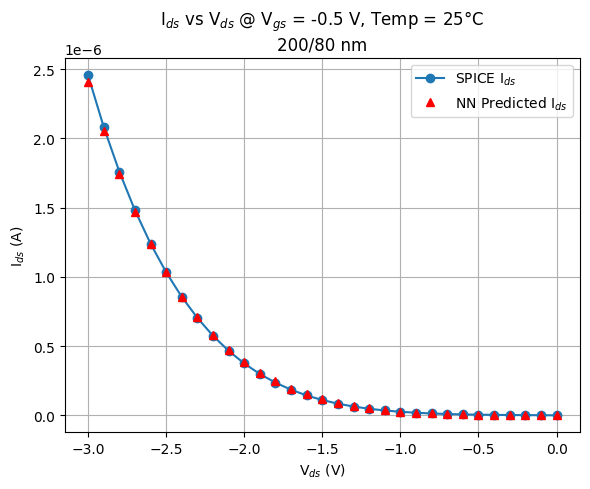

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


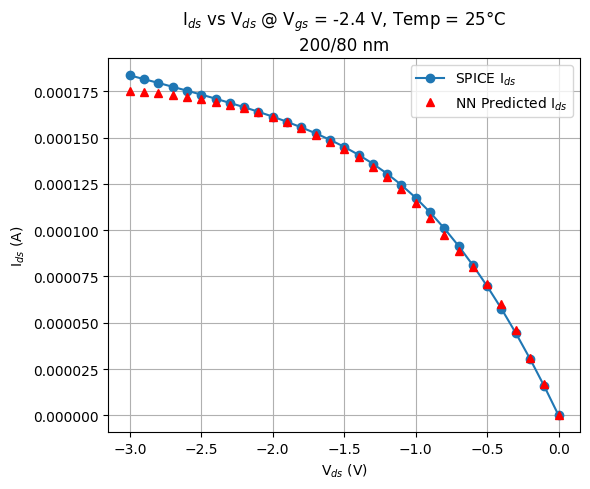

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


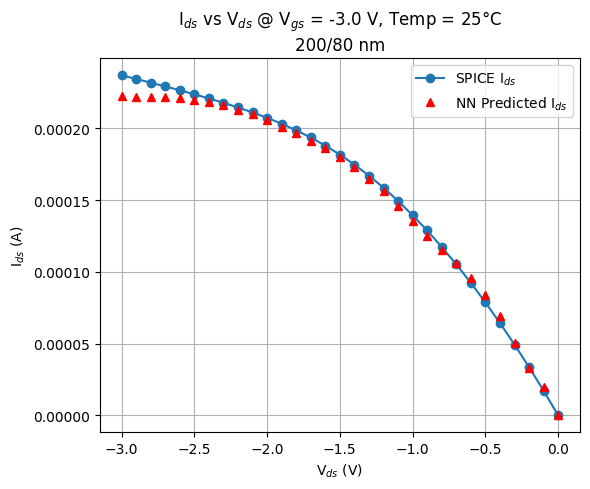

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n200/80 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


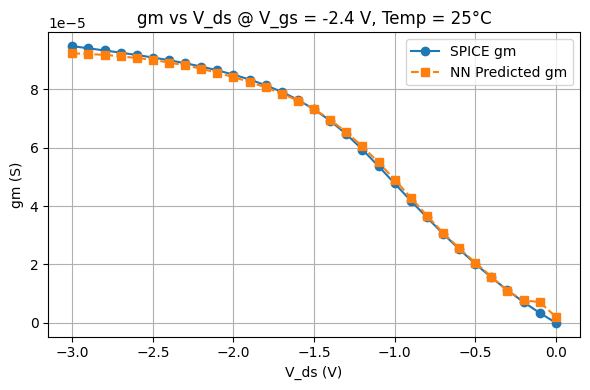

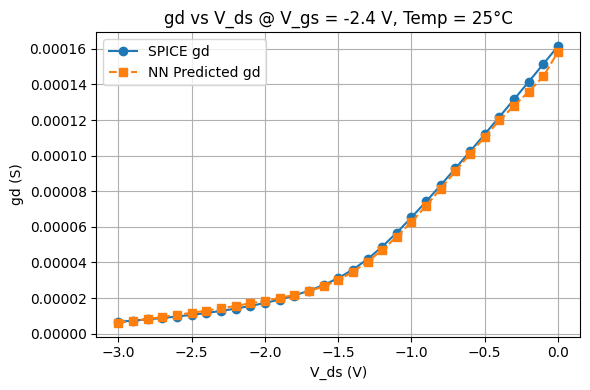

In [81]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set Vgs and temperature for comparison
VGS_TARGET = -2.4
TEMP_TARGET = 25

# Load and filter SPICE data
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
df_filtered = df_spice[mask].sort_values(by="Vds(V)")

if df_filtered.empty:
    print(f"⚠️ No data found for Vgs={VGS_TARGET} V, Temp={TEMP_TARGET}°C")
else:
    # Prepare input
    signature = device_signatures[2]  # Device 1
    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_plot_scaled = scaler.transform(X_plot)

    # Predict with model → outputs: [log10(Id), gm_scaled, gd_scaled]
    y_pred = model.predict(X_plot_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gd_pred_scaled = y_pred[:, 2]

    # Invert standard scaling
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()

    # True gm and gd
    gm_spice = df_filtered["gm"].values
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    # Plot gm
    plt.figure(figsize=(6, 4))
    plt.plot(vds_vals, gm_spice, "o-", label="SPICE gm")
    plt.plot(vds_vals, gm_pred, "s--", label="NN Predicted gm")
    plt.xlabel("V_ds (V)")
    plt.ylabel("gm (S)")
    plt.title(f"gm vs V_ds @ V_gs = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot gd
    plt.figure(figsize=(6, 4))
    plt.plot(vds_vals, gd_spice, "o-", label="SPICE gd")
    plt.plot(vds_vals, gd_pred, "s--", label="NN Predicted gd")
    plt.xlabel("V_ds (V)")
    plt.ylabel("gd (S)")
    plt.title(f"gd vs V_ds @ V_gs = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


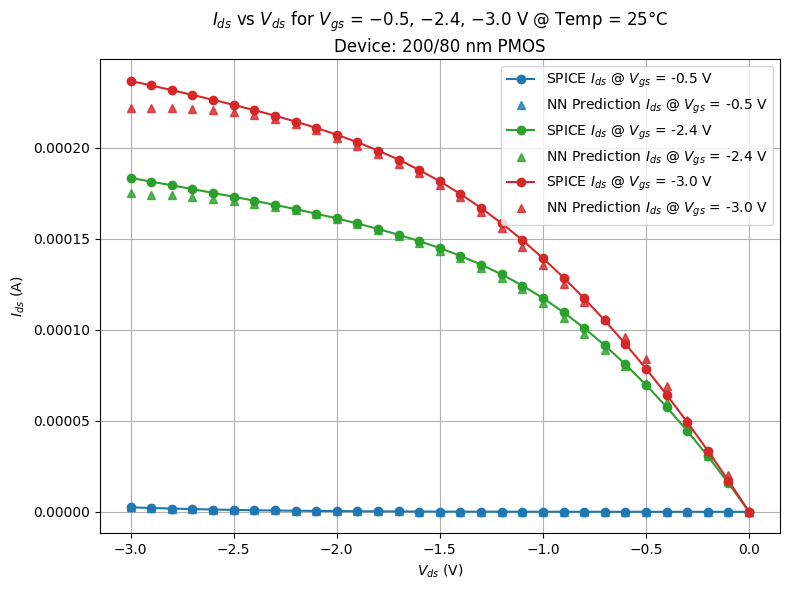

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 200/80 nm PMOS")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


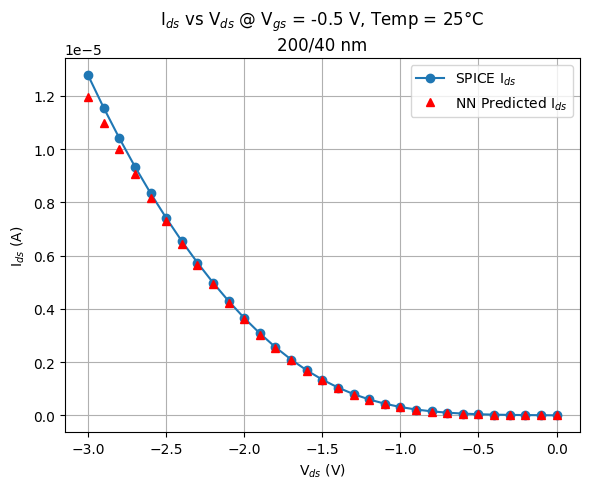

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


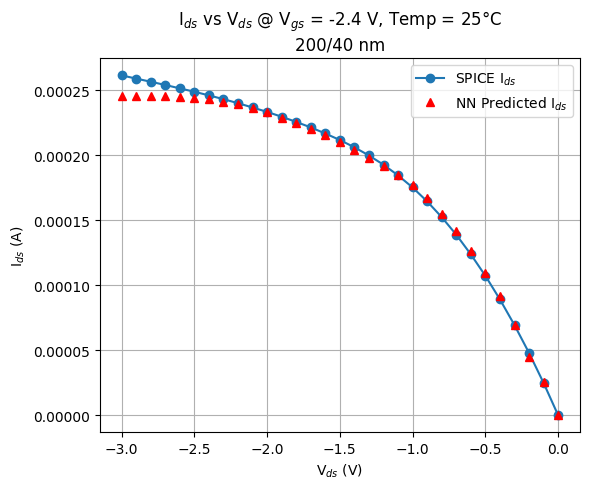

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


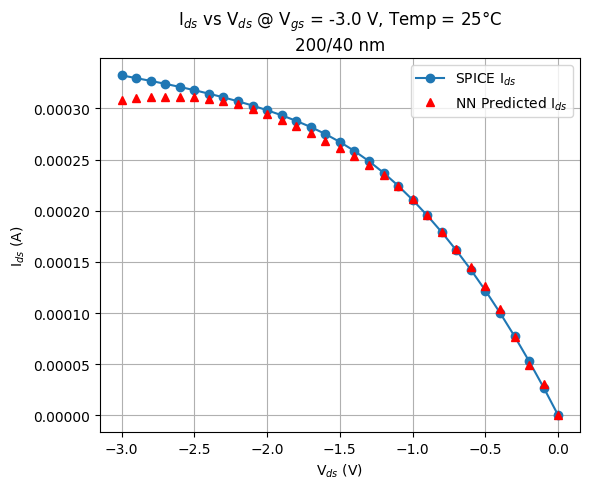

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n200/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


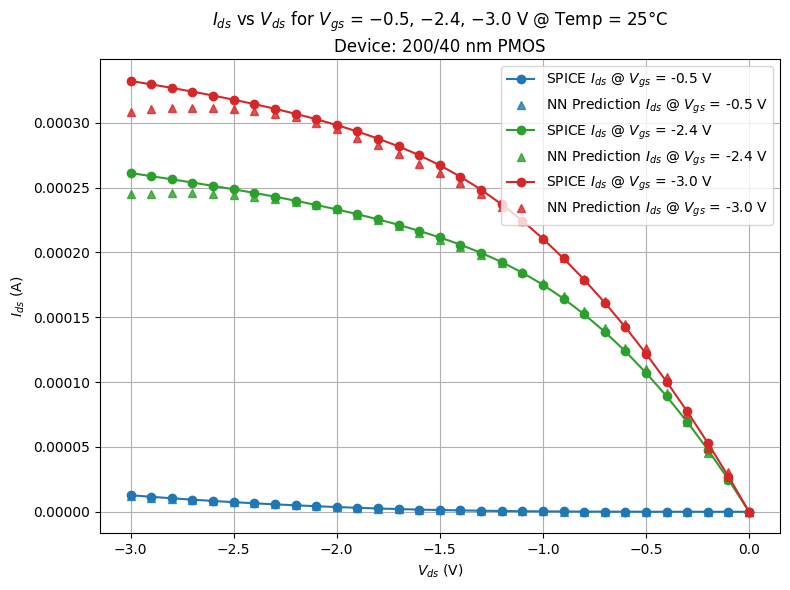

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 200/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


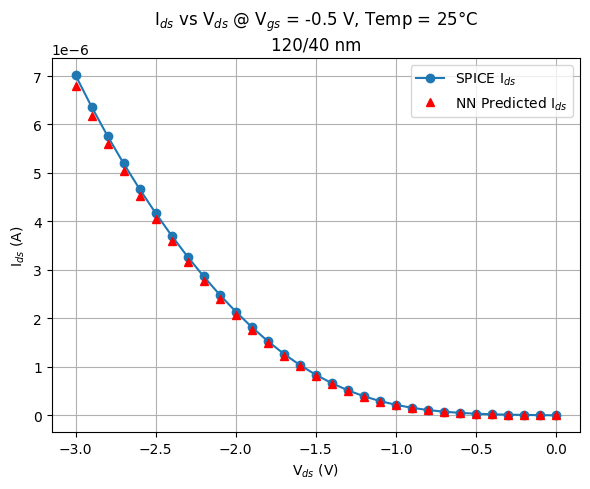

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


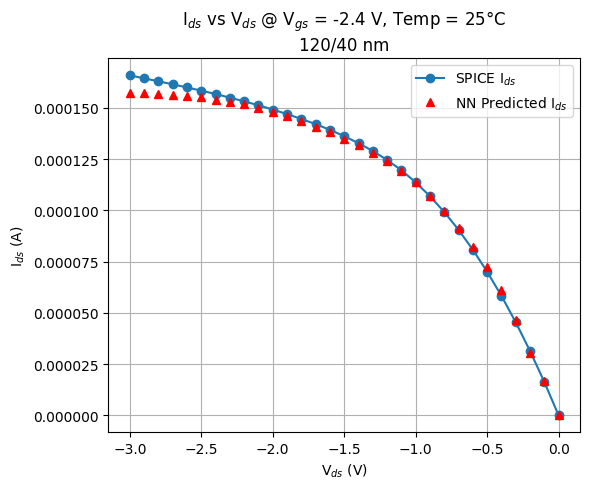

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


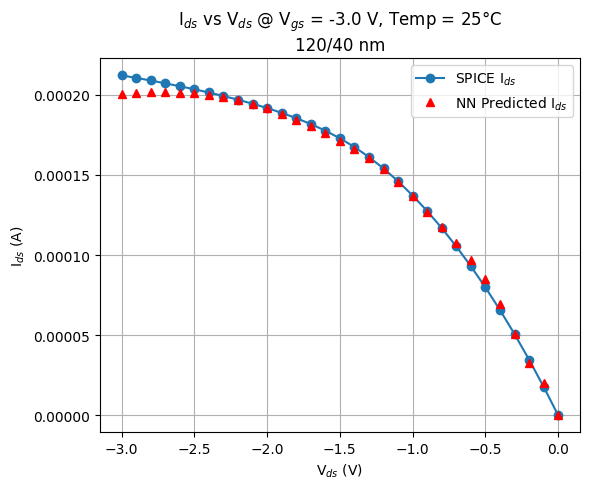

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_120_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n120/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


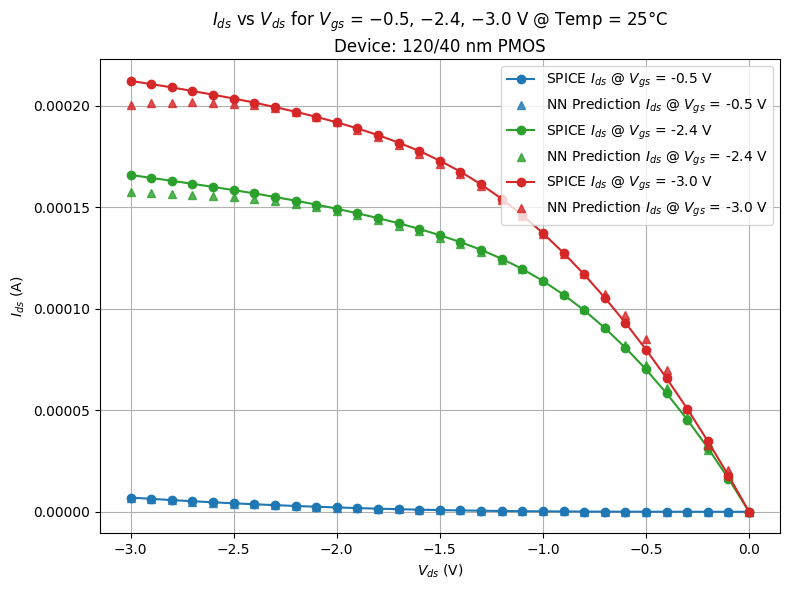

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 120/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


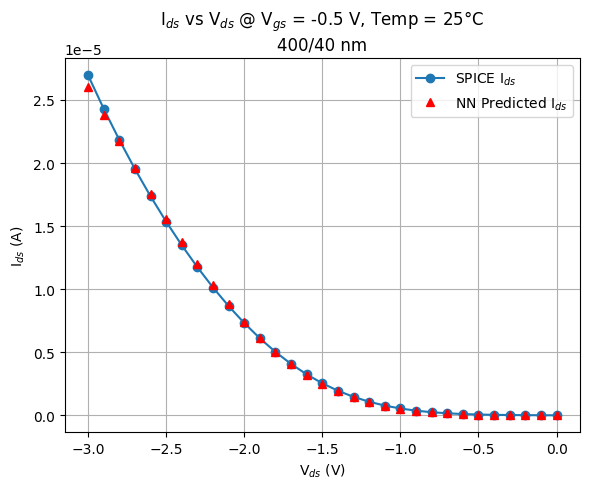

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


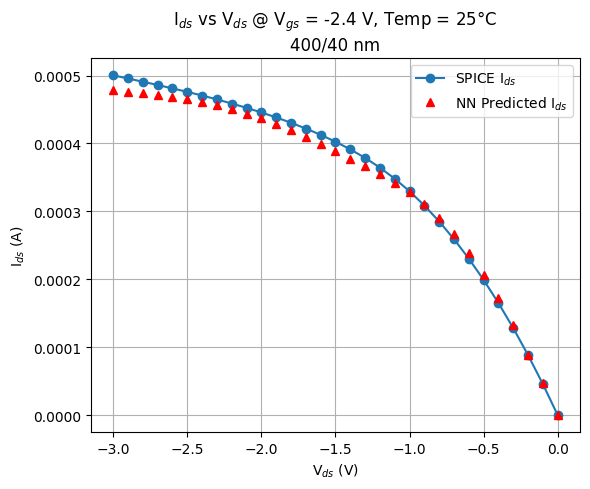

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


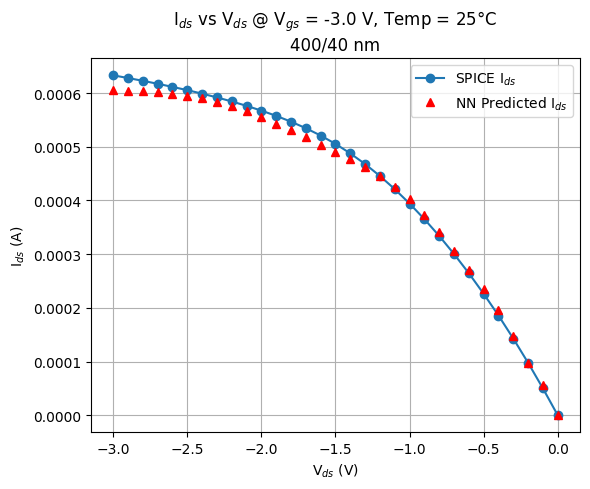

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_400_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n400/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


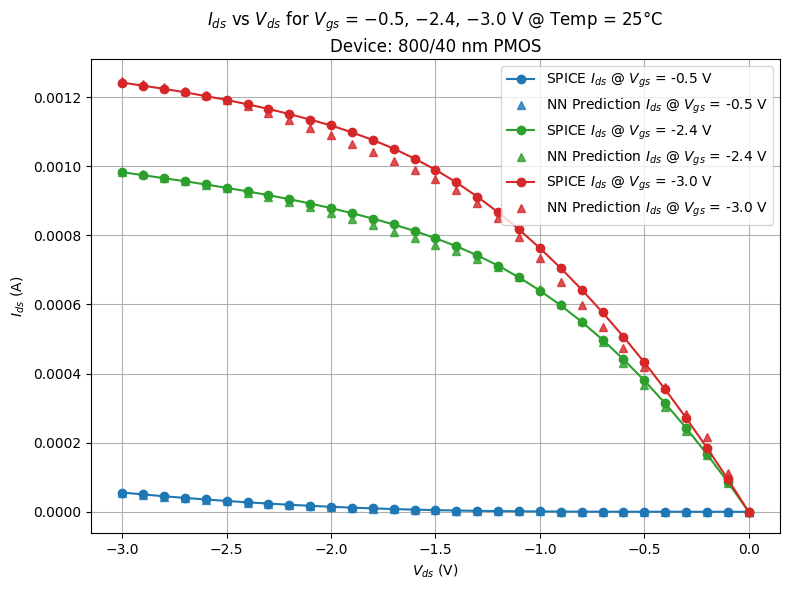

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 800/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


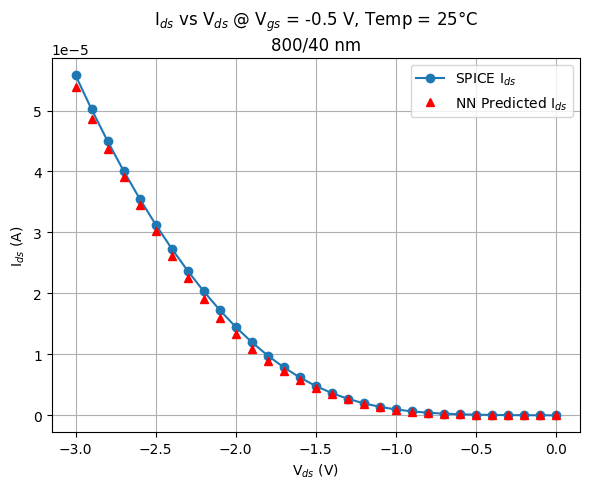

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


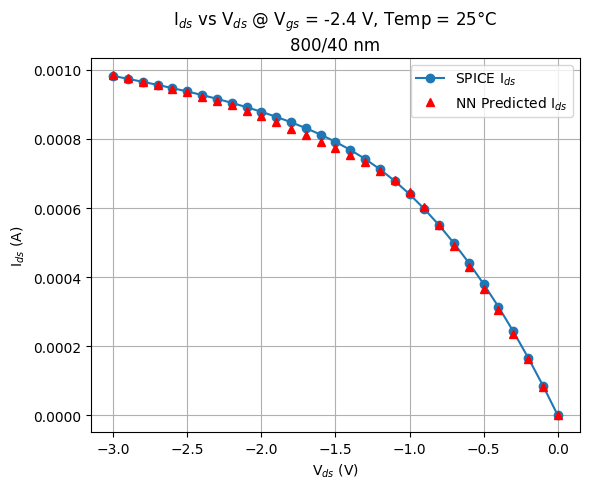

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


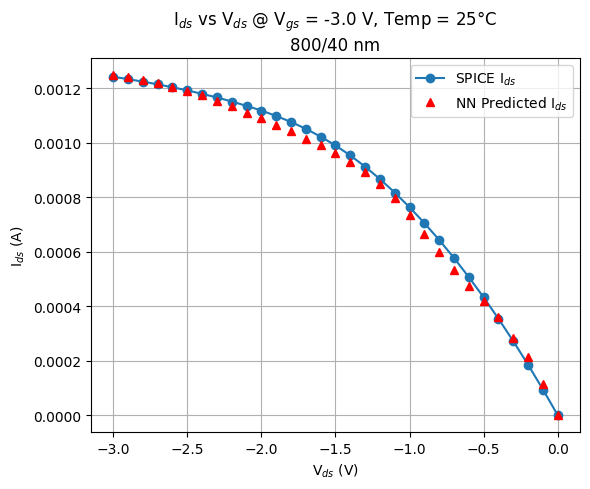

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n800/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


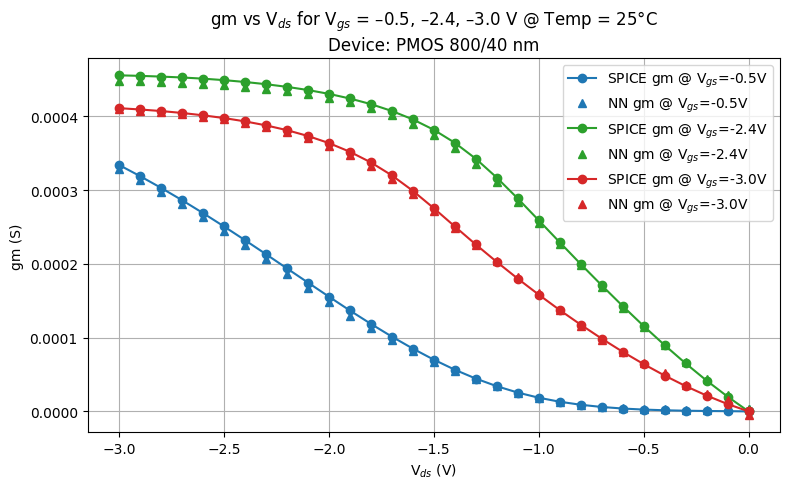

In [90]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 4  # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No data for Vgs = {VGS_TARGET} V")
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gm_spice = df_filtered["gm"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gm_spice, "o-", color=color, label=f"SPICE gm @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gm_pred, "^", color=color, linestyle='None', label=f"NN gm @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gm (S)")
plt.title("gm vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 800/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


<Figure size 800x500 with 0 Axes>

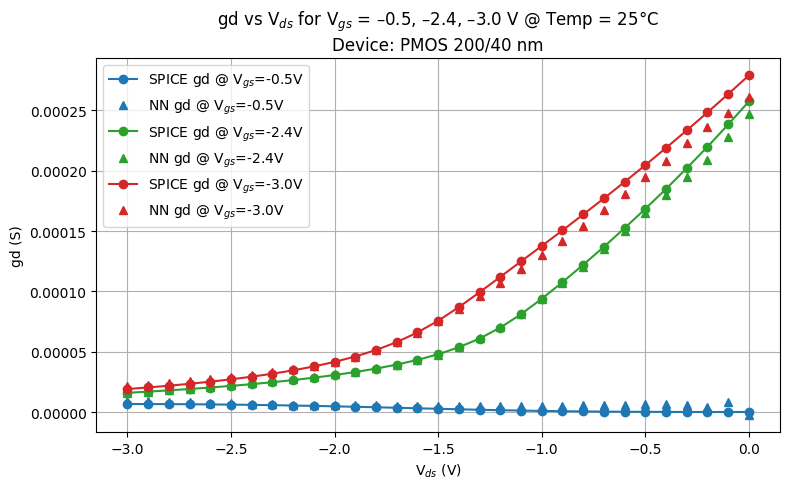

In [91]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 1 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 200/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


<Figure size 800x500 with 0 Axes>

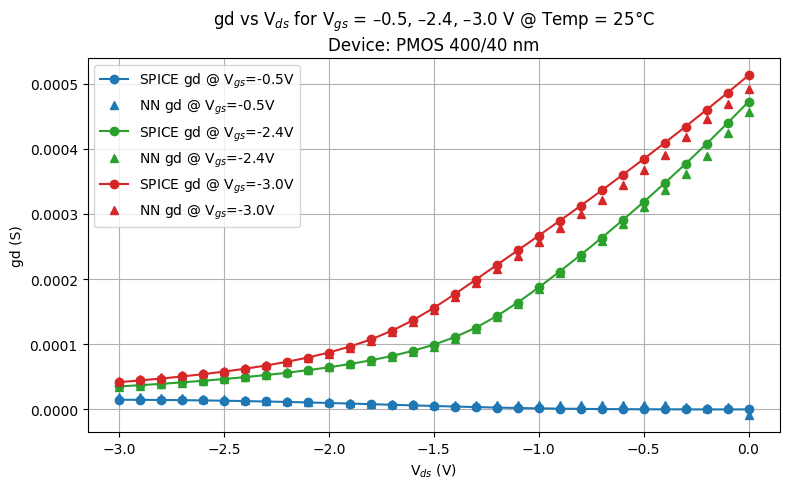

In [92]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 3 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_400_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 400/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


<Figure size 800x500 with 0 Axes>

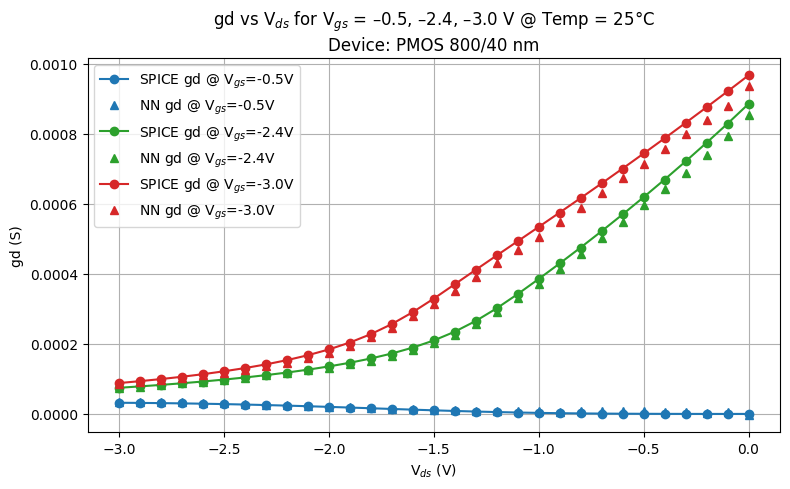

In [93]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 4 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 800/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


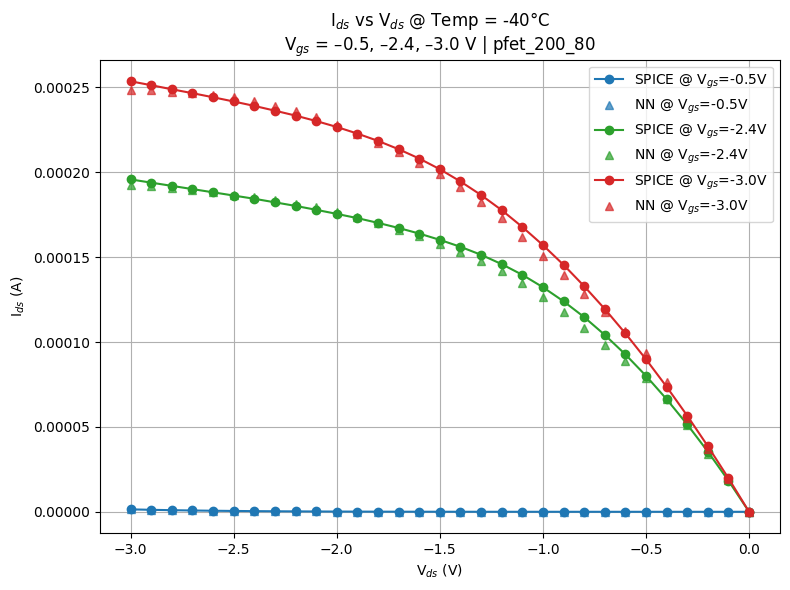

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


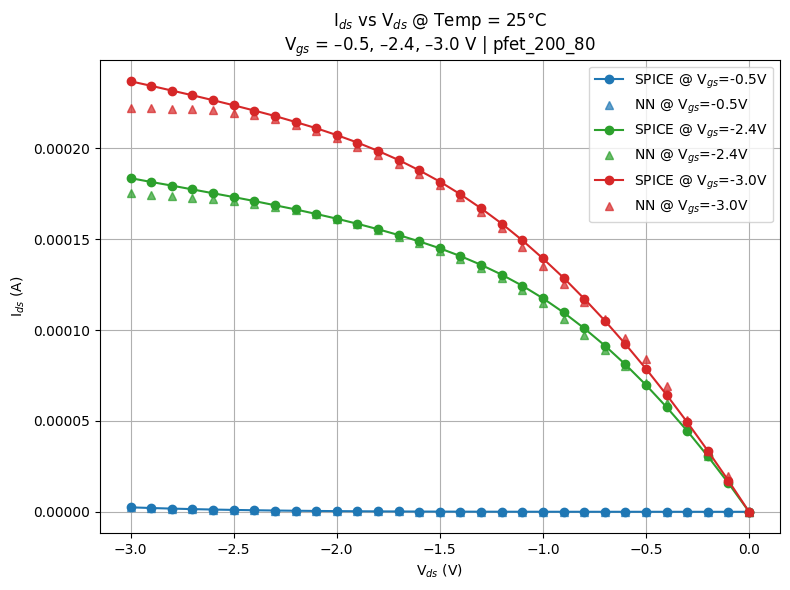

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


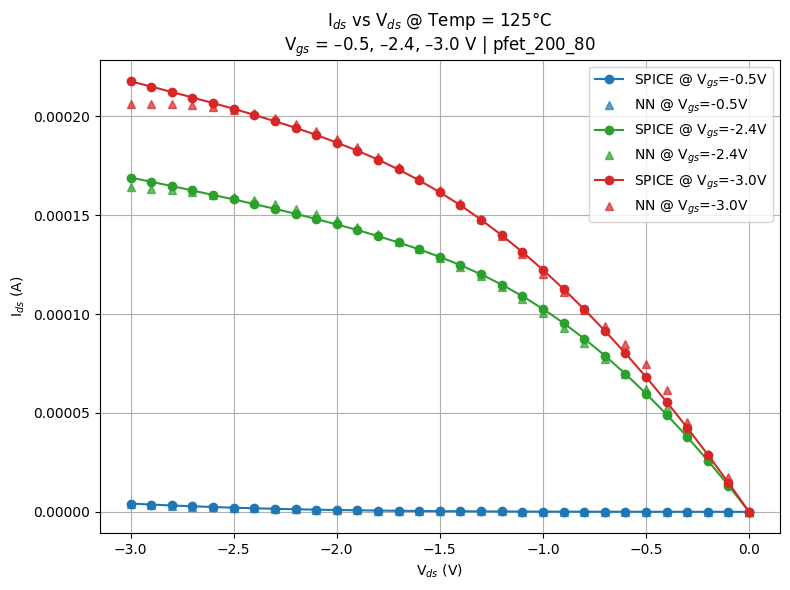

In [94]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 2  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_200_80.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_200_80")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


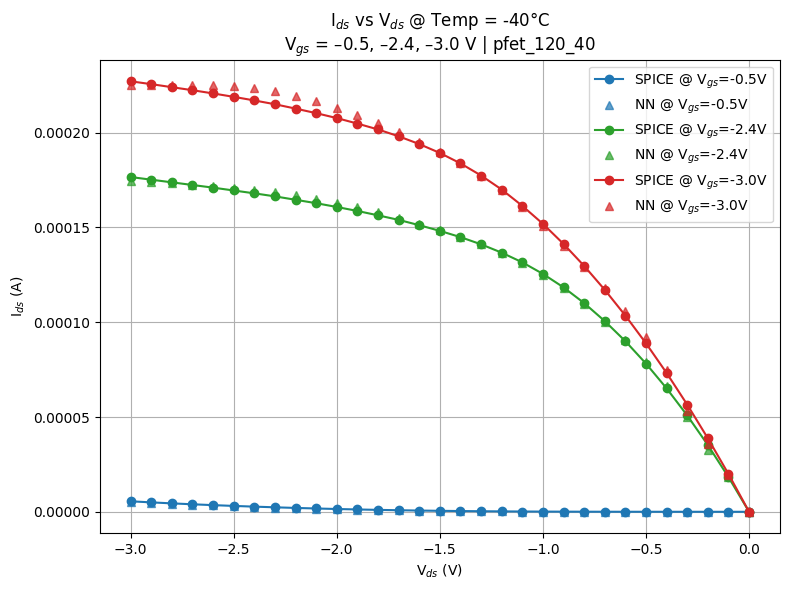

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


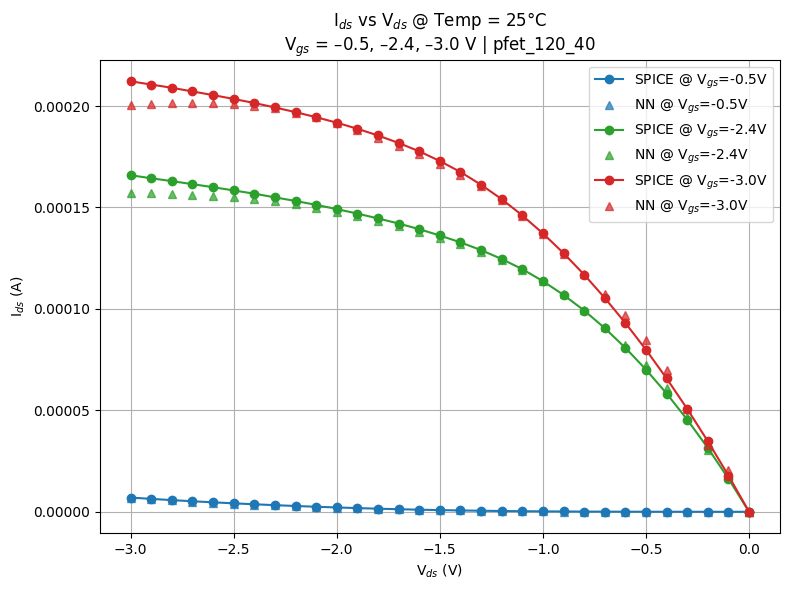

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


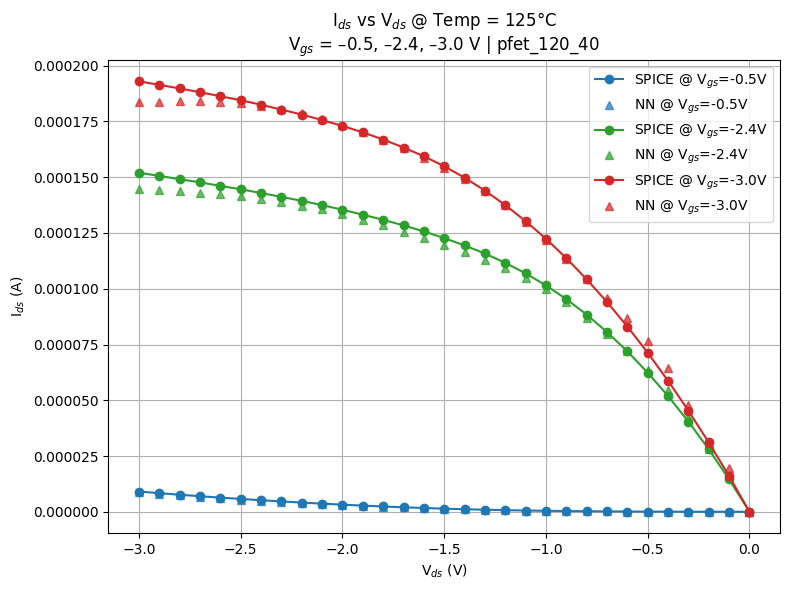

In [95]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 0  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_120_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_120_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


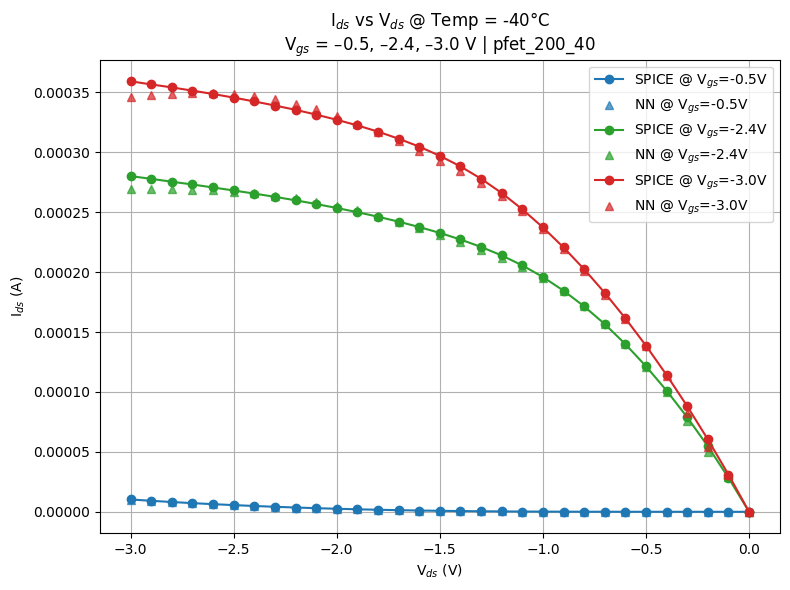

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


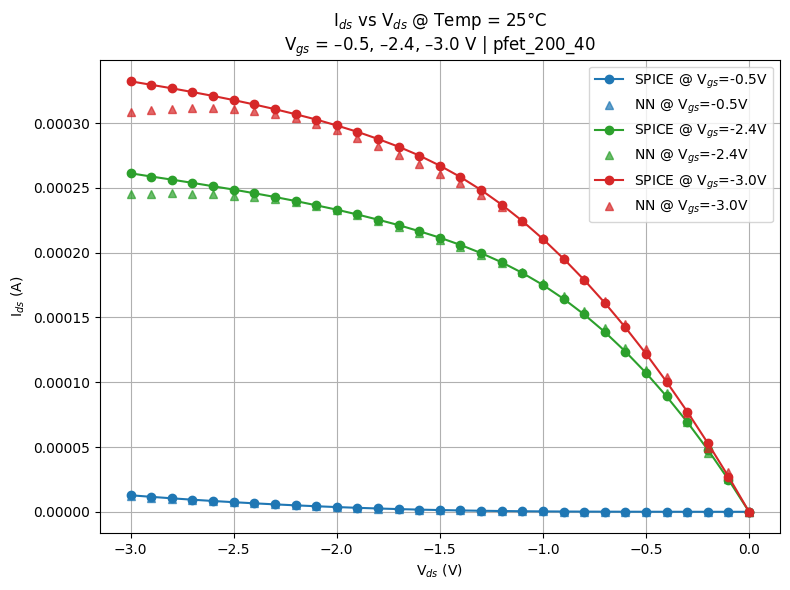

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


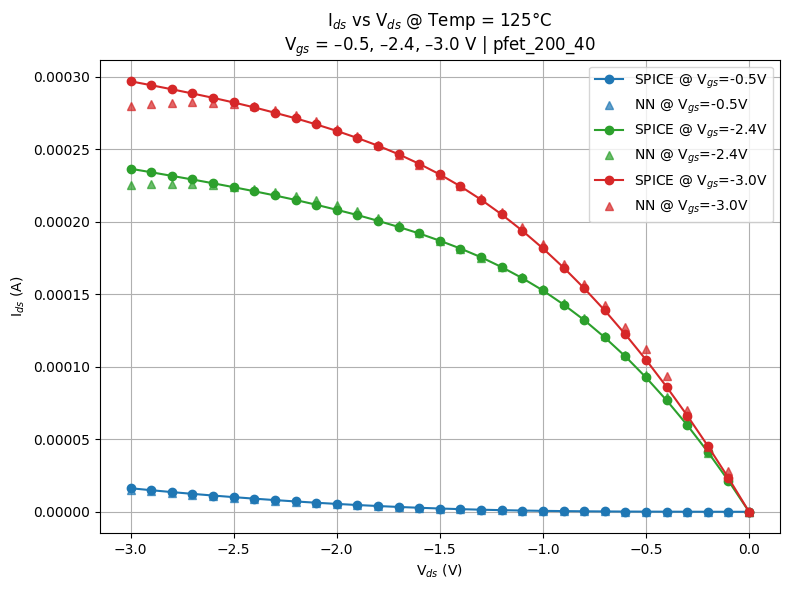

In [96]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 1  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_200_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_200_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


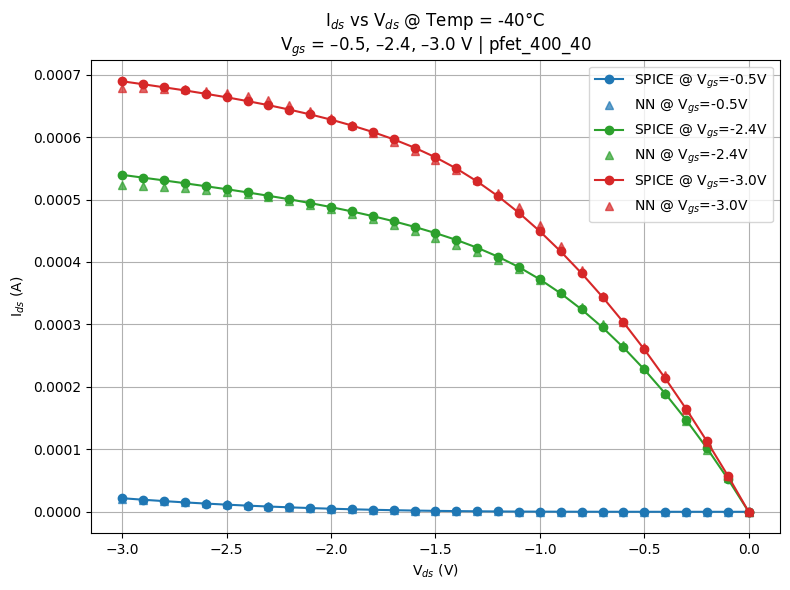

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


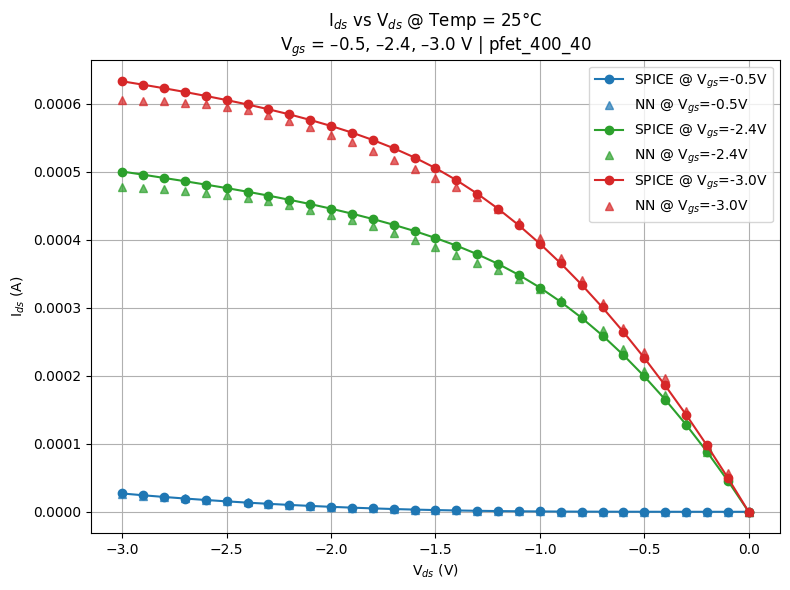

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


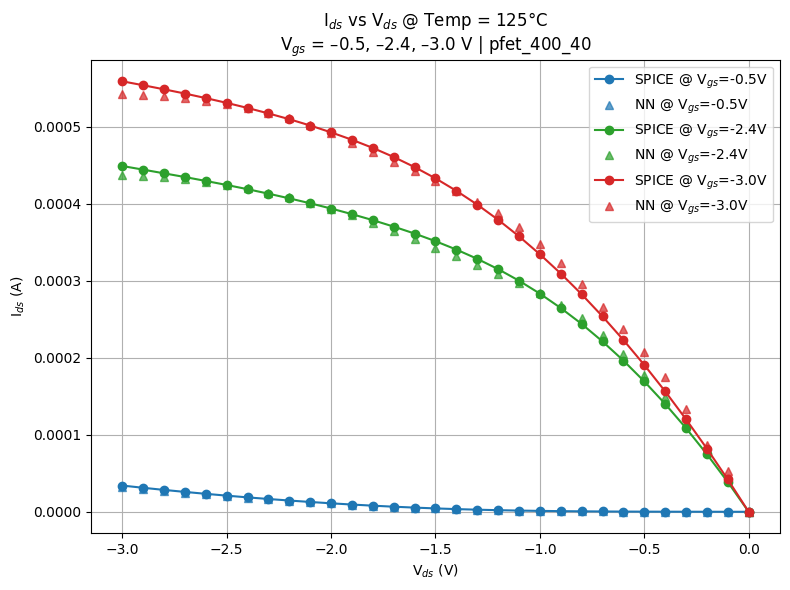

In [97]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 3  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_400_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_400_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


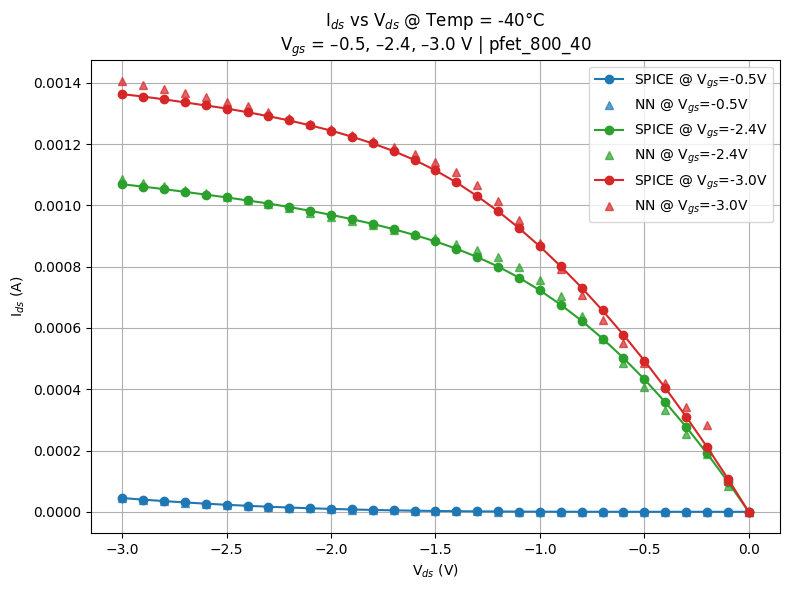

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


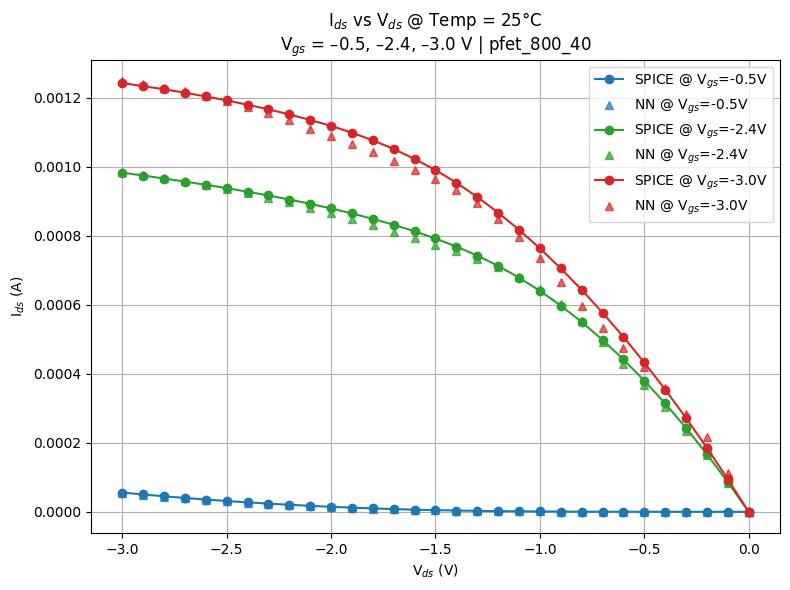

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


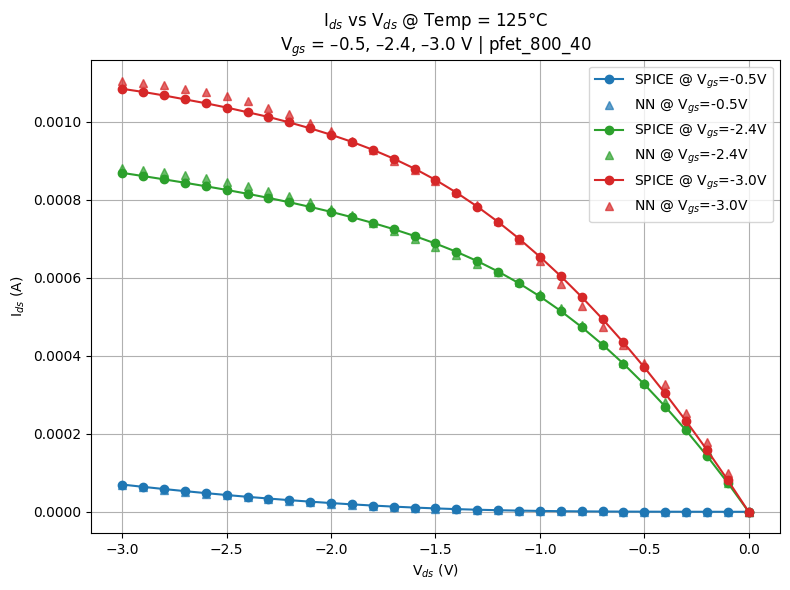

In [98]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 4  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_800_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


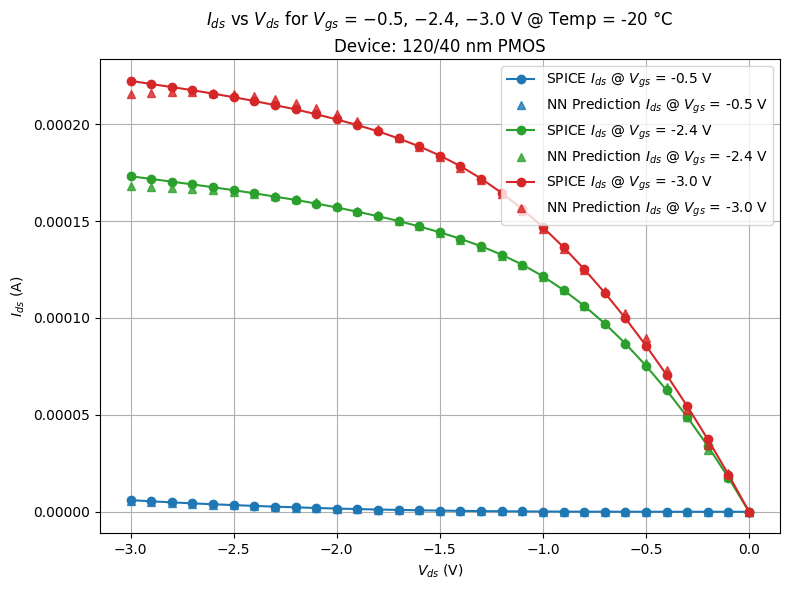

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40__-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 120/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


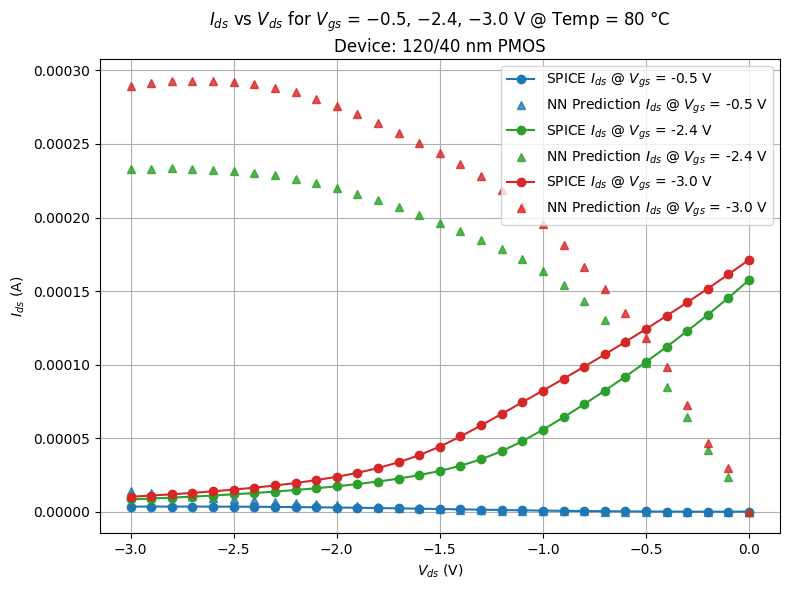

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40__-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 120/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


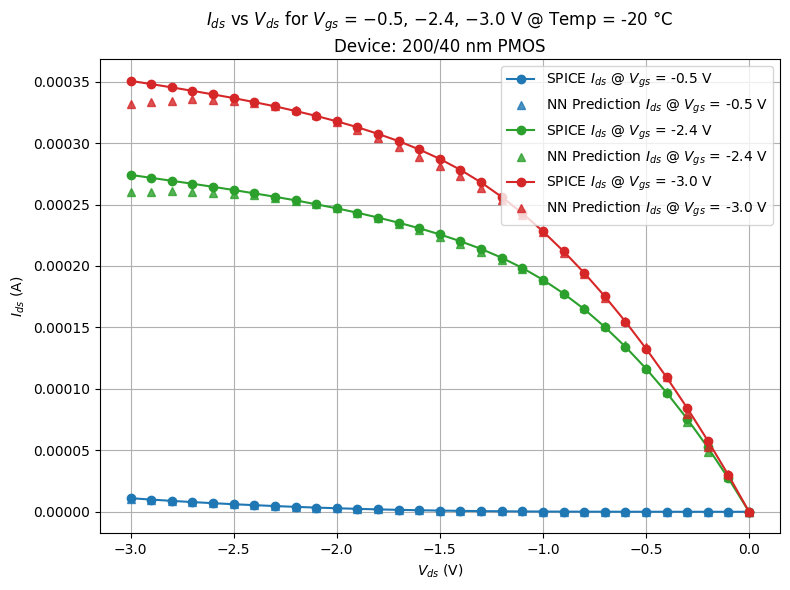

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 200/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


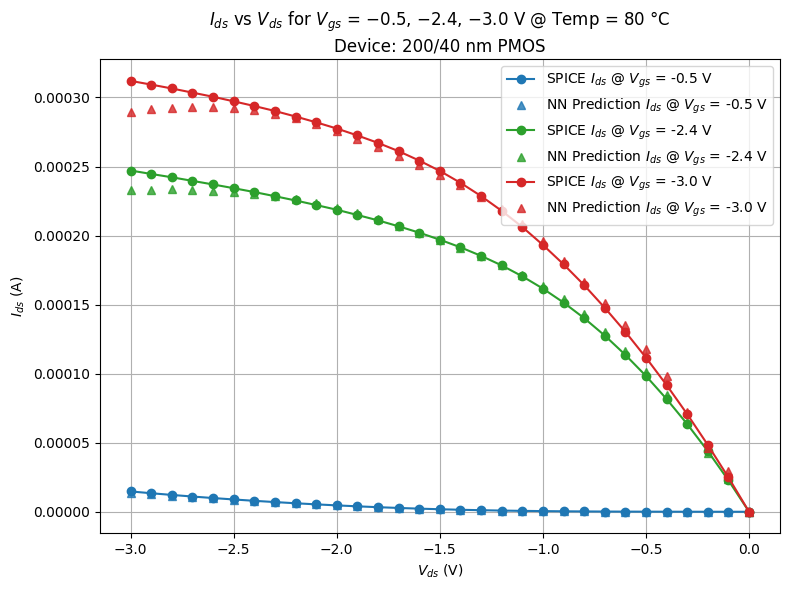

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 200/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


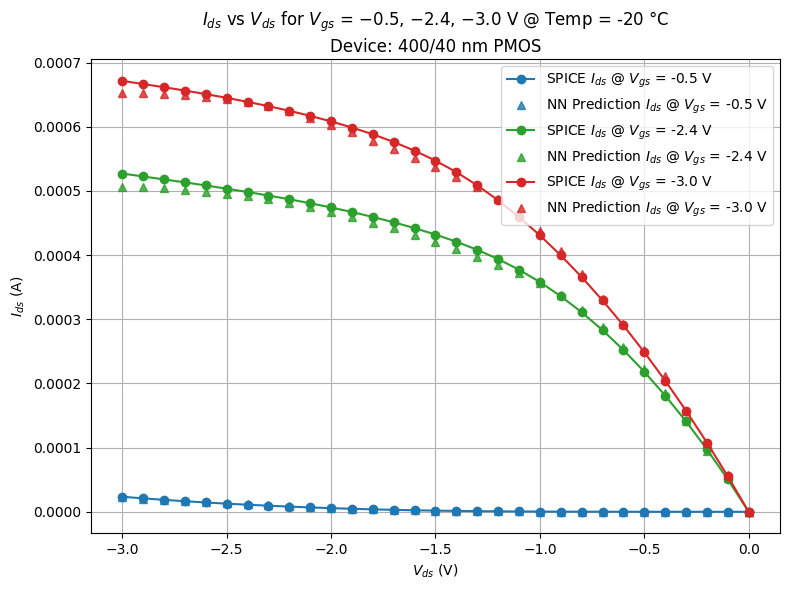

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 400/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


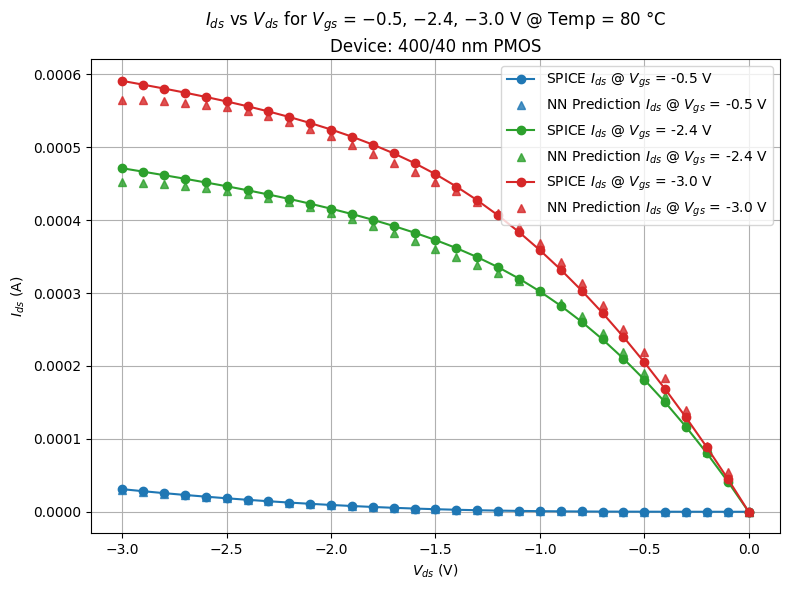

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 400/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


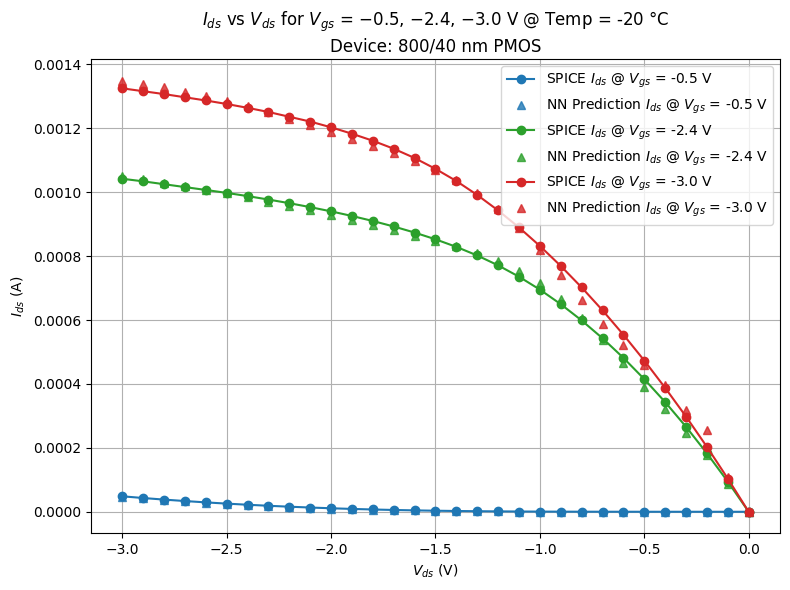

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_800_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 800/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


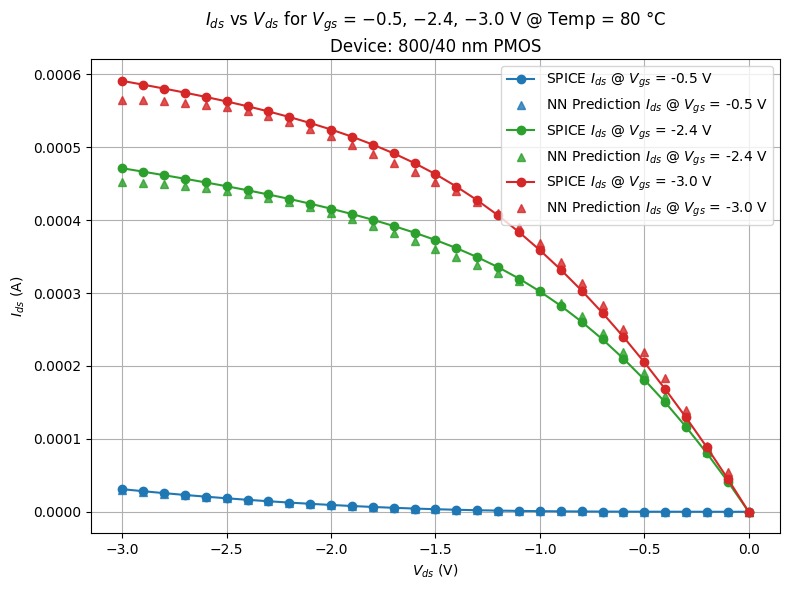

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 800/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()
